# Latest

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

def cycle_raw_comp_utilization_multi(csv_files, subplot_titles, figsize=(20, 9), 
                                   utilization_scale=None, cycles_scale=None,
                                   util_hlines_list=None, cycles_hlines_list=None,
                                   output_file=None):
    """
    Create side-by-side multi-axis line charts from multiple CSV files.
    
    Parameters:
    csv_files (list): List of CSV file paths
    subplot_titles (list): Title for each subplot
    figsize (tuple): Figure size (width, height)
    utilization_scale (tuple, optional): Y-axis scale for utilization
    cycles_scale (tuple, optional): Y-axis scale for cycles
    util_hlines_list (list of lists, optional): Y-values for horizontal lines on utilization axis for each plot
    cycles_hlines_list (list of lists, optional): Y-values for horizontal lines on cycles axis for each plot
    output_file (str, optional): Path to save the combined plot
    """
    font_uniform = 44
    axis_font = font_uniform
    legend_font = font_uniform
    tick_font = font_uniform
    x_tick_size = font_uniform
    subtitle_font = font_uniform
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    
    num_plots = len(csv_files)
    
    # Create subplots
    fig, axes = plt.subplots(1, num_plots, figsize=figsize, gridspec_kw={'wspace': 0.1})
    
    # Ensure axes is always a list
    if num_plots == 1:
        axes = [axes]
    
    # Process each subplot
    for plot_idx, (csv_file, subplot_title) in enumerate(zip(csv_files, subplot_titles)):
        ax1 = axes[plot_idx]
        
        # Read CSV file
        df_combined = pd.read_csv(csv_file)
        
        # Create display names from n_par_region column
        display_names = df_combined['n_par_region'].tolist()
        display_names = [f'{name}\n({128 // name})' for name in display_names]
        
        # Position of points on X axis
        x_pos = np.arange(len(display_names))
        
        # Remove individual x-axis labels - we'll add a shared one later
        if plot_idx == 0:
            ax1.set_xlabel('(a) Static Tiling', fontsize=axis_font, labelpad=85, fontweight='bold')
        else:
            ax1.set_xlabel('(b) Dynamic Tiling', fontsize=axis_font, labelpad=85, fontweight='bold')
        
        # Create first y-axis for utilization
        line1 = ax1.plot(x_pos, df_combined['utilization(%)'], 
                         color=color_palette[0], marker='o', linewidth=3, 
                         markersize=8, label=f'Compute Util.' if plot_idx == 0 else "")
        
        # Customize first y-axis (for utilization)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(display_names, ha='center', fontsize=x_tick_size)
        ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)

        
        
        # Only show y-label on leftmost plot
        if plot_idx == 0:
            ax1.set_ylabel('Utilization (%)', fontsize=axis_font, labelpad=10)
        
        # Create second y-axis for cycles
        ax2 = ax1.twinx()
        line2 = ax2.plot(x_pos, df_combined['cycles'], 
                         color=color_palette[2], marker='s', linewidth=3, 
                         markersize=8, label='Cycles' if plot_idx == 0 else "")
        
        # Customize second y-axis (for cycles)
        ax2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
        ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        ax2_offset_text = ax2.yaxis.get_offset_text()
        ax2_offset_text.set_fontsize(tick_font)
        ax2_offset_text.set_position((0.99, 1.02))
        
        # Only show y-label on rightmost plot
        if plot_idx == num_plots - 1:
            ax2.set_ylabel('Performance (cycles)', fontsize=axis_font, labelpad=10)
        
        # Set subplot title
        # ax1.set_title(subplot_title, fontsize=subtitle_font, fontweight='bold')
        
        # ==================== Set Range ====================
        if utilization_scale is not None:
            ax1.set_ylim(utilization_scale)
        if cycles_scale is not None:
            ax2.set_ylim(cycles_scale)
        
        # ==================== Add Red Horizontal Lines ====================
        # Add horizontal lines for utilization axis
        if util_hlines_list and plot_idx < len(util_hlines_list) and util_hlines_list[plot_idx]:
            for i, y_val in enumerate(util_hlines_list[plot_idx]):
                ax1.axhline(y=y_val, color='red', linestyle='--', linewidth=2, alpha=0.8)
                ax1.text(x_pos[-1], y_val + (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.02, 
                        f'Target: {y_val}%', 
                        color='red', fontsize=20, ha='right', va='bottom')
        
        # Add horizontal lines for cycles axis
        if cycles_hlines_list and plot_idx < len(cycles_hlines_list) and cycles_hlines_list[plot_idx]:
            for i, y_val in enumerate(cycles_hlines_list[plot_idx]):
                ax2.axhline(y=y_val, color='red', linestyle='--', linewidth=2, alpha=0.8)
                if i > 0:
                    percentile = 1
                    if y_val == 754098:
                        percentile = 5
                    ax2.text(x_pos[0], y_val + (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.02, 
                            f'   < {percentile}%', 
                            color='red', fontsize=x_tick_size, ha='left', va='bottom')
        
        # Add grid - Only horizontal grid lines
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Remove y-axis ticks and labels from non-edge plots for cleaner look
        if plot_idx > 0:
            ax1.tick_params(axis='y', left=False, labelleft=False)
        if plot_idx < num_plots - 1:
            ax2.tick_params(axis='y', right=False, labelright=False)
    
    # Add legend (only once, positioned at top)
    if num_plots > 0:
        # Get legend elements from the first plot
        lines1, labels1 = axes[0].get_legend_handles_labels()
        ax2_first = axes[0].get_shared_x_axes().get_siblings(axes[0])[0] if hasattr(axes[0], 'get_shared_x_axes') else None
        
        # Try to get the twinx axis from the first subplot
        lines2, labels2 = [], []
        for child in axes[0].get_figure().get_children():
            if hasattr(child, 'get_legend_handles_labels'):
                try:
                    temp_lines, temp_labels = child.get_legend_handles_labels()
                    if temp_labels and 'Cycles' in temp_labels:
                        lines2, labels2 = temp_lines, temp_labels
                        break
                except:
                    continue
        
        # If we couldn't find the cycles legend, create it manually
        if not lines2:
            # Create a dummy line for the legend
            dummy_line = plt.Line2D([0], [0], color=color_palette[2], marker='s', linewidth=3, markersize=8)
            lines2 = [dummy_line]
            labels2 = ['Cycles']
        
        all_handles = lines1 + lines2
        all_labels = labels1 + labels2
        fig.legend(all_handles, all_labels, loc='upper right', bbox_to_anchor=(0.91, 0.90), 
                  ncol=1, fontsize=legend_font)
    
    # Add shared x-axis label
    fig.text(0.5, -0.12, 'Parallel Regions (Experts per Region)', 
             ha='center', va='bottom', fontsize=axis_font)
    
    # Adjust layout
    plt.tight_layout()
    # Add some bottom padding for the shared x-label
    plt.subplots_adjust(bottom=0.15)
    
    # Save plot if output file specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Combined plot saved to {output_file}")
    
    # Show plot
    # plt.show()
    
    return fig

/tmp/ipykernel_3137926/4091535690.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Combined plot saved to ./timeshare_mem_bound/figure/qwen_iter032_layer_012_combined_comp_util.pdf


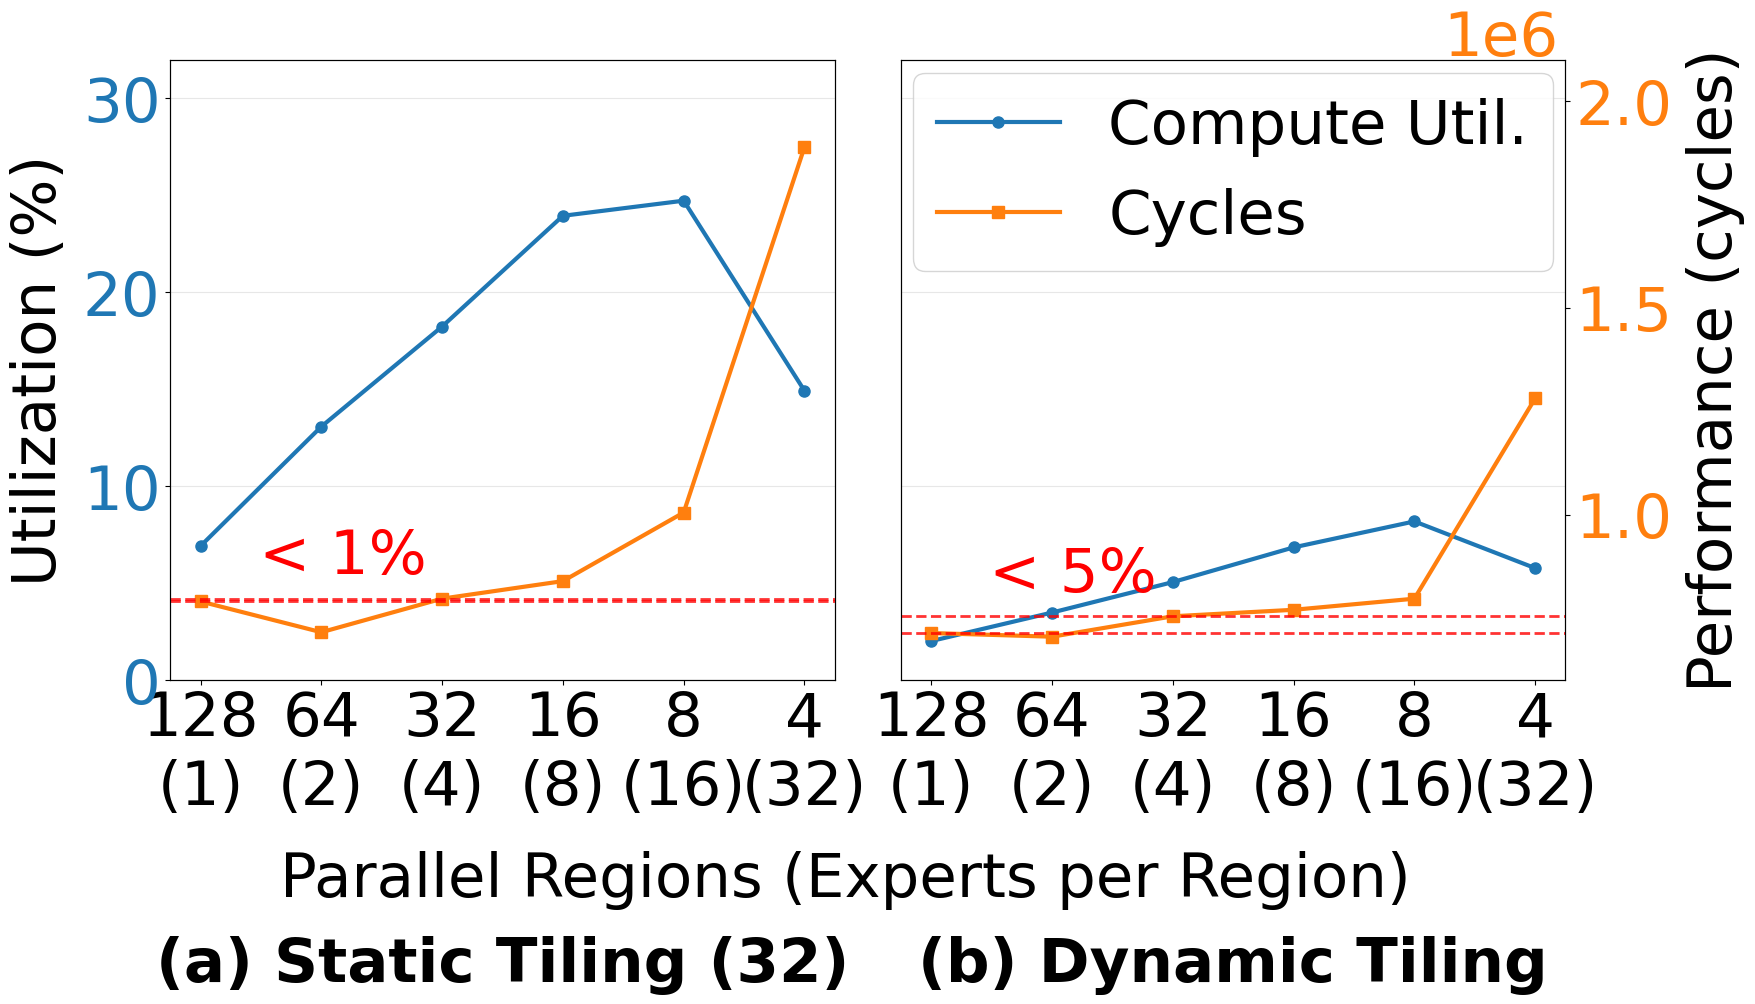

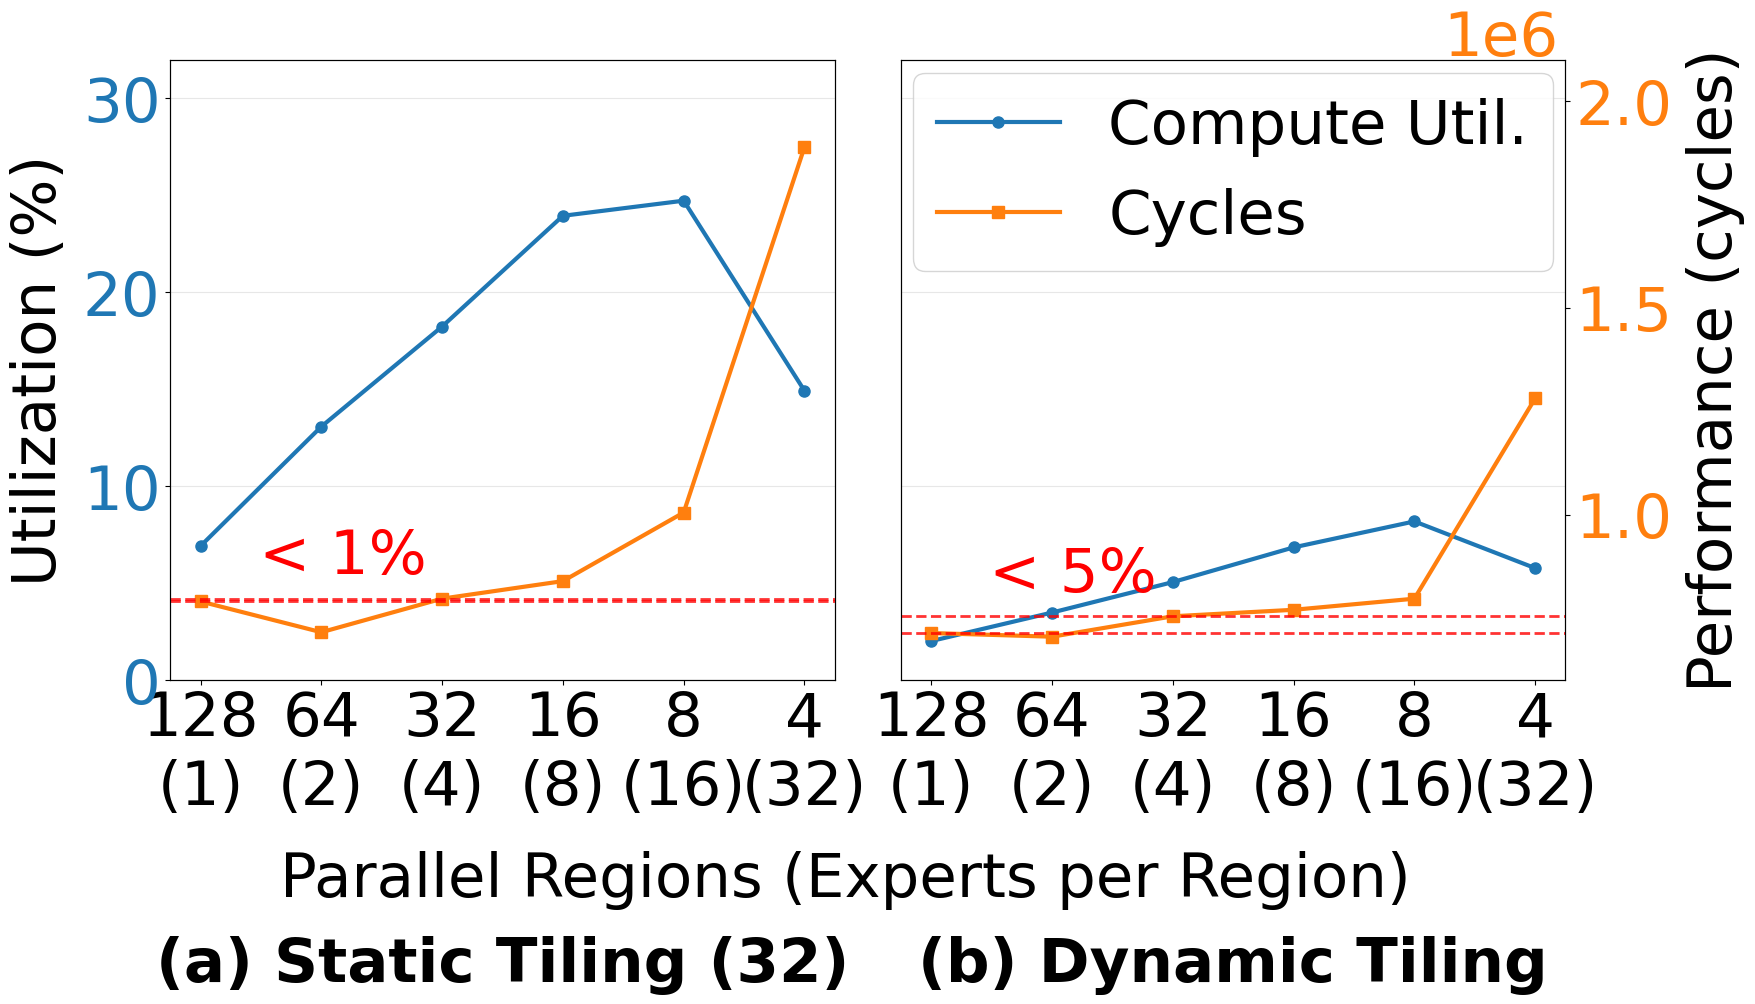

In [161]:
# Your existing parameters
csv_file_1='./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_revet_128_4.csv'
csv_file_2='./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_round_1_f48_timeshare_membound_dyn_tile_128_4.csv'

utilization_scale = (0,32)
cycles_scale = (0.6*1e6,2.1*1e6)


# Option 2: Use the new side-by-side function
csv_files = [csv_file_1, csv_file_2]
subplot_titles = ['N=32', 'N=Dynamic']
cycles_hlines_list = [[789895, 796725], [713539, 754098]]
output_file_combined = "./timeshare_mem_bound/figure/qwen_iter032_layer_012_combined_comp_util.pdf"

cycle_raw_comp_utilization_multi(
    csv_files=csv_files,
    subplot_titles=subplot_titles,
    figsize=(18, 8.5),
    utilization_scale=utilization_scale,
    cycles_scale=cycles_scale,
    cycles_hlines_list=cycles_hlines_list,
    output_file=output_file_combined
)

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

def create_two_plots_pdf(csv_file, output_pdf, cycles_scale=None, on_chip_scale=None, 
                         allocated_flops_scale=None, bandwidth_scale_2=None, cycles_scale_2=None):
    """
    Create a single PDF with two plots arranged vertically [2,1] with equal box sizes.
    
    Parameters:
    csv_file (str): Path to CSV file
    output_pdf (str): Path to save the PDF
    cycles_scale (tuple, optional): Y-axis scale for cycles (plot 1)
    on_chip_scale (tuple, optional): Y-axis scale for on-chip requirement
    allocated_flops_scale (tuple, optional): Y-axis scale for allocated FLOPS
    bandwidth_scale_2 (tuple, optional): Y-axis scale for bandwidth utilization (plot 2)
    cycles_scale_2 (tuple, optional): Y-axis scale for cycles (plot 2)
    """

    cycles_color_idx = 2
    on_chip_color_idx = 4
    allocated_flops_color_idx = 8
    bandwidth_color_idx = 18
    
    font_uniform = 44
    axis_font = font_uniform
    legend_font = font_uniform
    tick_font = font_uniform
    x_tick_size = font_uniform
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    print(color_palette)
    
    # Read CSV file
    df_combined = pd.read_csv(csv_file)
    
    # Create display names from n_par_region column
    display_names = df_combined['n_par_region'].tolist()
    display_names = [f'{name}\n({128 // name})' for name in display_names]
    
    # Position of points on X axis
    x_pos = np.arange(len(display_names))
    
    # Create figure with subplots - adjusted for vertical [2,1] layout
    fig = plt.figure(figsize=(13, 14))
    
    # Use gridspec for better control over subplot positioning
    from matplotlib.gridspec import GridSpec
    gs = GridSpec(2, 1, figure=fig, left=0.1, right=0.85, bottom=0.1, top=0.95, hspace=0.15)
    
    # ==================== FIRST SUBPLOT (TOP): Three-axis plot ====================
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Create first y-axis for cycles
    line1 = ax1.plot(x_pos, df_combined['cycles'], 
                     color=color_palette[cycles_color_idx], marker='o', linewidth=3, 
                     markersize=8, label=f'Cycles')
    
    # Customize first y-axis - NO X-AXIS LABELS for top plot
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([])  # Remove x-tick labels
    ax1.tick_params(axis='y', labelcolor=color_palette[cycles_color_idx], labelsize=tick_font)
    ax1.tick_params(axis='x', bottom=False)  # Remove x-tick marks
    
    ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax1_offset_text = ax1.yaxis.get_offset_text()
    ax1_offset_text.set_fontsize(tick_font)
    ax1_offset_text.set_position((-0.1, 1.02))
    ax1.set_ylabel('Performance\n(Cycles)', fontsize=axis_font, labelpad=10)
    
    # Create second y-axis for on_chip_requirement_bytes
    ax1_2 = ax1.twinx()
    line2 = ax1_2.plot(x_pos, df_combined['on_chip_requirement_bytes'] / 1000, 
                       color=color_palette[on_chip_color_idx], marker='s', linewidth=3, 
                       markersize=8, label='On-Chip Mem.')
    
    # Customize second y-axis
    ax1_2.tick_params(axis='y', labelcolor=color_palette[on_chip_color_idx], labelsize=tick_font)
    ax1_2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax1_2_offset_text = ax1_2.yaxis.get_offset_text()
    ax1_2_offset_text.set_fontsize(tick_font)
    ax1_2_offset_text.set_position((0.89, 1.02))
    
    ax1_2.set_ylabel('Memory (KB)', fontsize=axis_font, labelpad=5)
    
    # Create third y-axis for allocated_flops
    ax1_3 = ax1.twinx()
    ax1_3.spines['right'].set_position(('outward', 120))  # Increased from 95 to 120
    
    line3 = ax1_3.plot(x_pos, df_combined['allocated_flops'], 
                       color=color_palette[allocated_flops_color_idx], marker='^', linewidth=3, 
                       markersize=8, label=f'Allocated Comp.')
    
    # Customize third y-axis
    ax1_3.tick_params(axis='y', labelcolor=color_palette[allocated_flops_color_idx], labelsize=tick_font)
    ax1_3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax1_3_offset_text = ax1_3.yaxis.get_offset_text()
    ax1_3_offset_text.set_fontsize(tick_font)
    ax1_3_offset_text.set_position((1, 1.02))
    ax1_3.set_ylabel('Compute\n(FLOPs/cycle)', fontsize=axis_font, labelpad=10)
    
    # Set scales for first plot
    if cycles_scale is not None:
        ax1.set_ylim(cycles_scale)
    if on_chip_scale is not None:
        ax1_2.set_ylim(on_chip_scale)
    if allocated_flops_scale is not None:
        ax1_3.set_ylim(allocated_flops_scale)
    
    # Combine legends for first plot
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_2.get_legend_handles_labels()
    lines3, labels3 = ax1_3.get_legend_handles_labels()
    all_handles1 = lines1 + lines2 + lines3
    all_labels1 = labels1 + labels2 + labels3
    ax1.legend(all_handles1, all_labels1, loc='upper right', fontsize=legend_font)
    
    ax1.grid(True, alpha=0.3, axis='y')  # Only horizontal grid lines
    ax1.text(0.02, 0.95, '(a)', fontsize=x_tick_size, fontweight='bold', 
             transform=ax1.transAxes, va='top')
    
    # ==================== SECOND SUBPLOT (BOTTOM): Off-chip bandwidth plot ====================
    ax2 = fig.add_subplot(gs[1, 0])
    
    mem_bw = 1024  # (bytes/cycle)
    
    # Create first y-axis for cycles (now on the LEFT)
    line5 = ax2.plot(x_pos, df_combined['cycles'], 
                     color=color_palette[cycles_color_idx], marker='s', linewidth=3, 
                     markersize=8, label='Cycles')
    
    # Customize first y-axis - WITH X-AXIS LABELS for bottom plot
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(display_names, ha='center', fontsize=x_tick_size)
    ax2.tick_params(axis='y', labelcolor=color_palette[cycles_color_idx], labelsize=tick_font)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_offset_text = ax2.yaxis.get_offset_text()
    ax2_offset_text.set_fontsize(tick_font)
    ax2_offset_text.set_position((-0.1, 1.02))
    ax2.set_ylabel('Performance\n(Cycles)', fontsize=axis_font, labelpad=10)
    
    # Create second y-axis for bandwidth utilization (now on the RIGHT)
    ax2_2 = ax2.twinx()
    line4 = ax2_2.plot(x_pos, (df_combined['off_chip_traffic_bytes']/df_combined['cycles'])/mem_bw*100, 
                       color=color_palette[bandwidth_color_idx], marker='o', linewidth=3, 
                       markersize=8, label=f'Off-chip BW Util.')
    
    # Customize second y-axis
    ax2_2.tick_params(axis='y', labelcolor=color_palette[bandwidth_color_idx], labelsize=tick_font)
    ax2_2.set_ylabel('Utilization (%)', fontsize=axis_font, labelpad=0)
    
    # Set scales for second plot
    if cycles_scale_2 is not None:
        ax2.set_ylim(cycles_scale_2)  # Now ax2 is cycles
    if bandwidth_scale_2 is not None:
        ax2_2.set_ylim(bandwidth_scale_2)  # Now ax2_2 is bandwidth
    
    # Combine legends for second plot
    lines5, labels5 = ax2.get_legend_handles_labels()
    lines4, labels4 = ax2_2.get_legend_handles_labels()
    all_handles2 = lines5 + lines4  # Swapped order to match new axis arrangement
    all_labels2 = labels5 + labels4
    ax2.legend(all_handles2, all_labels2, loc='upper right', fontsize=legend_font)
    
    ax2.grid(True, alpha=0.3, axis='y')  # Only horizontal grid lines
    ax2.text(0.02, 0.95, '(b)', fontsize=x_tick_size, fontweight='bold', 
             transform=ax2.transAxes, va='top')
    
    # Add shared x-axis label at the bottom
    fig.text(0.5, -0.03, 'Parallel Regions (Experts per Region)', 
             fontsize=x_tick_size+4, ha='center', va='bottom')
    
    # Save to PDF
    with PdfPages(output_pdf) as pdf:
        pdf.savefig(fig, bbox_inches='tight', dpi=300)
        print(f"Two plots saved to {output_pdf}")
    
    # Show the plot
    plt.show()
    plt.close()

# Example usage:
# create_two_plots_pdf('your_data.csv', 'two_plots.pdf')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), (1.0, 0.4980392156862745, 0.054901960784313725), (1.0, 0.7333333333333333, 0.47058823529411764), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.596078431372549, 0.8745098039215686, 0.5411764705882353), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (1.0, 0.596078431372549, 0.5882352941176471), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.7725490196078432, 0.6901960784313725, 0.8352941176470589), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.7686274509803922, 0.611764705882353, 0.5803921568627451), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.9686274509803922, 0.7137254901960784, 0.8235294117647058), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7803921568627451, 0.7803921568627451, 0.7803921568627451), (0.7372549019607844, 0.7411764705882353, 0.1333

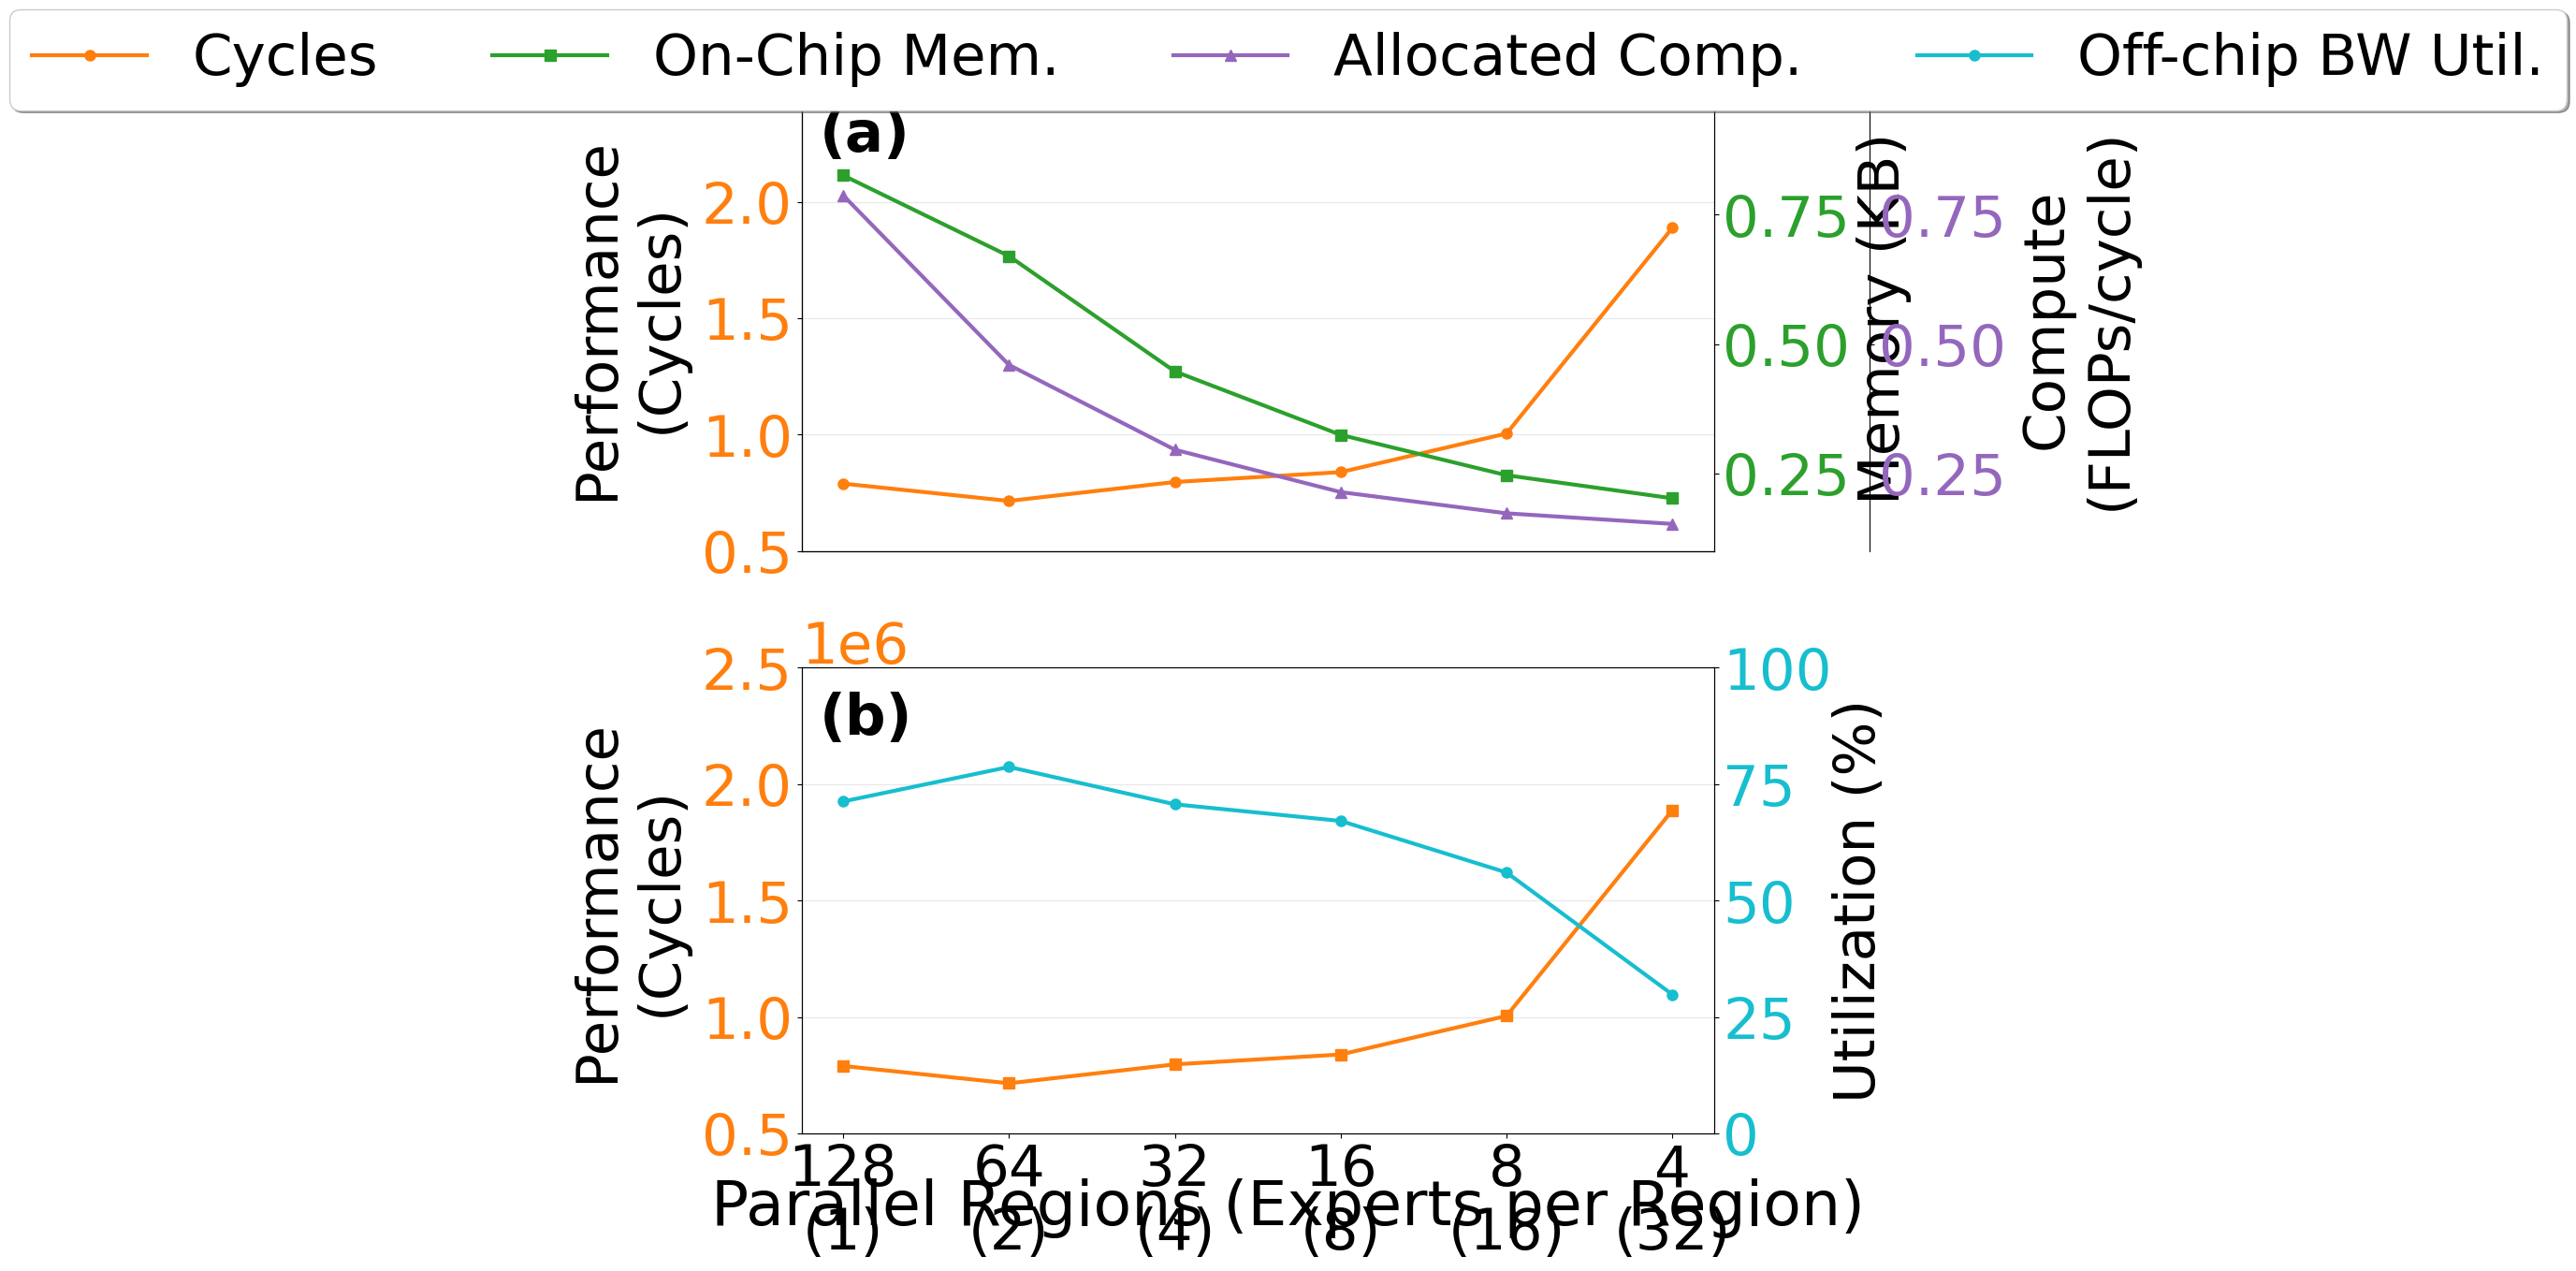

In [165]:
outfile = "./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_n32.pdf"

on_chip_scale=(1*1e4,10*1e4)
allocated_flops_scale=(1*1e5,10*1e5)
cycles_scale=(0.5*1e6,2.5*1e6)
bandwidth_scale_2=(0,100)

# on_chip_scale=None
# allocated_flops_scale=None
# cycles_scale=None
# bandwidth_scale_2=None


create_two_plots_pdf('./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_revet_128_4.csv',
    outfile,
    cycles_scale=cycles_scale, 
    on_chip_scale=on_chip_scale, 
    allocated_flops_scale=allocated_flops_scale, 
    bandwidth_scale_2=bandwidth_scale_2, 
    cycles_scale_2=cycles_scale)

In [217]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

def create_two_plots_pdf(csv_file, output_pdf, cycles_scale=None, on_chip_scale=None, 
                         allocated_flops_scale=None, bandwidth_scale_2=None, cycles_scale_2=None):
    """
    Create a single PDF with two plots arranged vertically [2,1] with equal box sizes.
    
    Parameters:
    csv_file (str): Path to CSV file
    output_pdf (str): Path to save the PDF
    cycles_scale (tuple, optional): Y-axis scale for cycles (plot 1)
    on_chip_scale (tuple, optional): Y-axis scale for on-chip requirement
    allocated_flops_scale (tuple, optional): Y-axis scale for allocated FLOPS
    bandwidth_scale_2 (tuple, optional): Y-axis scale for bandwidth utilization (plot 2)
    cycles_scale_2 (tuple, optional): Y-axis scale for cycles (plot 2)
    """

    cycles_color_idx = 2
    on_chip_color_idx = 4
    allocated_flops_color_idx = 8
    bandwidth_color_idx = 18
    
    font_uniform = 44
    axis_font = font_uniform
    legend_font = font_uniform
    tick_font = font_uniform
    x_tick_size = font_uniform
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    print(color_palette)
    
    # Read CSV file
    df_combined = pd.read_csv(csv_file)
    
    # Create display names from n_par_region column
    display_names = df_combined['n_par_region'].tolist()
    display_names = [f'{name}\n({128 // name})' for name in display_names]
    
    # Position of points on X axis
    x_pos = np.arange(len(display_names))
    
    # Create figure with subplots - adjusted for vertical [2,1] layout
    # Increased hspace to accommodate shared legend
    fig = plt.figure(figsize=(9, 11))
    
    # Use gridspec for better control over subplot positioning
    from matplotlib.gridspec import GridSpec
    gs = GridSpec(2, 1, figure=fig, left=0.1, right=0.85, bottom=0.1, top=0.9, hspace=0.25)
    
    # ==================== FIRST SUBPLOT (TOP): Three-axis plot ====================
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Create first y-axis for cycles
    line1 = ax1.plot(x_pos, df_combined['cycles'], 
                     color=color_palette[cycles_color_idx], marker='o', linewidth=3, 
                     markersize=8, label=f'Cycles')
    
    # Customize first y-axis - NO X-AXIS LABELS for top plot
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([])  # Remove x-tick labels
    ax1.tick_params(axis='y', labelcolor=color_palette[cycles_color_idx], labelsize=tick_font)
    ax1.tick_params(axis='x', bottom=False)  # Remove x-tick marks
    
    ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax1_offset_text = ax1.yaxis.get_offset_text()
    ax1_offset_text.set_fontsize(tick_font)
    ax1_offset_text.set_position((-0.15, 1.02))
    ax1.set_ylabel('Performance\n(Cycles)', fontsize=axis_font, labelpad=10)
    
    # Create second y-axis for on_chip_requirement_bytes
    ax1_2 = ax1.twinx()
    line2 = ax1_2.plot(x_pos, df_combined['on_chip_requirement_bytes'] / 1000, 
                       color=color_palette[on_chip_color_idx], marker='s', linewidth=3, 
                       markersize=8, label=f'On-Chip\nMemory')
    
    # Customize second y-axis
    ax1_2.tick_params(axis='y', labelcolor=color_palette[on_chip_color_idx], labelsize=tick_font)
    ax1_2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax1_2_offset_text = ax1_2.yaxis.get_offset_text()
    ax1_2_offset_text.set_fontsize(tick_font)
    ax1_2_offset_text.set_position((0.8, 1.02))
    
    ax1_2.set_ylabel('Memory (KB)', fontsize=axis_font, labelpad=5)
    
    # Create third y-axis for allocated_flops
    ax1_3 = ax1.twinx()
    ax1_3.spines['right'].set_position(('outward', 120))  # Increased from 95 to 120
    
    line3 = ax1_3.plot(x_pos, df_combined['allocated_flops'], 
                       color=color_palette[allocated_flops_color_idx], marker='^', linewidth=3, 
                       markersize=8, label=f'Allocated\nCompute')
    
    # Customize third y-axis
    ax1_3.tick_params(axis='y', labelcolor=color_palette[allocated_flops_color_idx], labelsize=tick_font)
    ax1_3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax1_3_offset_text = ax1_3.yaxis.get_offset_text()
    ax1_3_offset_text.set_fontsize(tick_font)
    ax1_3_offset_text.set_position((1, 1.02))
    ax1_3.set_ylabel('Compute\n(FLOPs/cycle)', fontsize=axis_font, labelpad=10)
    
    # Set scales for first plot
    if cycles_scale is not None:
        ax1.set_ylim(cycles_scale)
    if on_chip_scale is not None:
        ax1_2.set_ylim(on_chip_scale)
    if allocated_flops_scale is not None:
        ax1_3.set_ylim(allocated_flops_scale)
    
    # NO individual legend for first plot - will be handled by shared legend
    
    ax1.grid(True, alpha=0.3, axis='y')  # Only horizontal grid lines
    ax1.text(0.02, 0.95, '(a)', fontsize=x_tick_size, fontweight='bold', 
             transform=ax1.transAxes, va='top')
    
    # ==================== SECOND SUBPLOT (BOTTOM): Off-chip bandwidth plot ====================
    ax2 = fig.add_subplot(gs[1, 0])
    
    mem_bw = 1024  # (bytes/cycle)
    
    # Create first y-axis for cycles (now on the LEFT)
    line5 = ax2.plot(x_pos, df_combined['cycles'], 
                     color=color_palette[cycles_color_idx], marker='s', linewidth=3, 
                     markersize=8, label='Cycles')
    
    # Customize first y-axis - WITH X-AXIS LABELS for bottom plot
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(display_names, ha='center', fontsize=x_tick_size)
    ax2.tick_params(axis='y', labelcolor=color_palette[cycles_color_idx], labelsize=tick_font)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_offset_text = ax2.yaxis.get_offset_text()
    ax2_offset_text.set_fontsize(tick_font)
    ax2_offset_text.set_position((-0.1, 1.02))
    ax2.set_ylabel('Performance\n(Cycles)', fontsize=axis_font, labelpad=10)
    
    # Create second y-axis for bandwidth utilization (now on the RIGHT)
    ax2_2 = ax2.twinx()
    line4 = ax2_2.plot(x_pos, (df_combined['off_chip_traffic_bytes']/df_combined['cycles'])/mem_bw*100, 
                       color=color_palette[bandwidth_color_idx], marker='o', linewidth=3, 
                       markersize=8, label=f'Off-chip\nBW Util.')
    
    # Customize second y-axis
    ax2_2.tick_params(axis='y', labelcolor=color_palette[bandwidth_color_idx], labelsize=tick_font)
    ax2_2.set_ylabel('Utilization (%)', fontsize=axis_font, labelpad=0)
    
    # Set scales for second plot
    if cycles_scale_2 is not None:
        ax2.set_ylim(cycles_scale_2)  # Now ax2 is cycles
    if bandwidth_scale_2 is not None:
        ax2_2.set_ylim(bandwidth_scale_2)  # Now ax2_2 is bandwidth
    
    # NO individual legend for second plot - will be handled by shared legend
    
    ax2.grid(True, alpha=0.3, axis='y')  # Only horizontal grid lines
    ax2.text(0.02, 0.95, '(b)', fontsize=x_tick_size, fontweight='bold', 
             transform=ax2.transAxes, va='top')
    
    # ==================== SHARED LEGEND FOR ALL FOUR METRICS ====================
    # Collect all handles and labels from all axes
    lines1, labels1 = ax1.get_legend_handles_labels()      # Cycles from top plot
    lines2, labels2 = ax1_2.get_legend_handles_labels()    # On-Chip Memory
    lines3, labels3 = ax1_3.get_legend_handles_labels()    # Allocated FLOPS
    lines4, labels4 = ax2_2.get_legend_handles_labels()    # BW Utilization from bottom plot
    
    # Combine all handles and labels
    all_handles = lines1 + lines2 + lines3 + lines4
    all_labels = labels1 + labels2 + labels3 + labels4
    
    # Create single shared legend at the top of the figure
    fig.legend(all_handles, all_labels, 
              loc='upper center', 
              bbox_to_anchor=(1.38, 0.55),  # Top of figure
              ncol=1,  # One column - all four metrics in a vertical stack [4,1]
              fontsize=legend_font,
              frameon=True,
              fancybox=True,
              shadow=True)
    
    # Add shared x-axis label at the bottom
    fig.text(0.5, -0.11, 'Parallel Regions (Experts per Region)', 
             fontsize=x_tick_size+4, ha='center', va='bottom')
    
    # Save to PDF
    with PdfPages(output_pdf) as pdf:
        pdf.savefig(fig, bbox_inches='tight', dpi=300)
        print(f"Two plots saved to {output_pdf}")
    
    # Show the plot
    plt.show()
    plt.close()

# Example usage:
# create_two_plots_pdf('your_data.csv', 'two_plots.pdf')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), (1.0, 0.4980392156862745, 0.054901960784313725), (1.0, 0.7333333333333333, 0.47058823529411764), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.596078431372549, 0.8745098039215686, 0.5411764705882353), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (1.0, 0.596078431372549, 0.5882352941176471), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.7725490196078432, 0.6901960784313725, 0.8352941176470589), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.7686274509803922, 0.611764705882353, 0.5803921568627451), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.9686274509803922, 0.7137254901960784, 0.8235294117647058), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7803921568627451, 0.7803921568627451, 0.7803921568627451), (0.7372549019607844, 0.7411764705882353, 0.1333

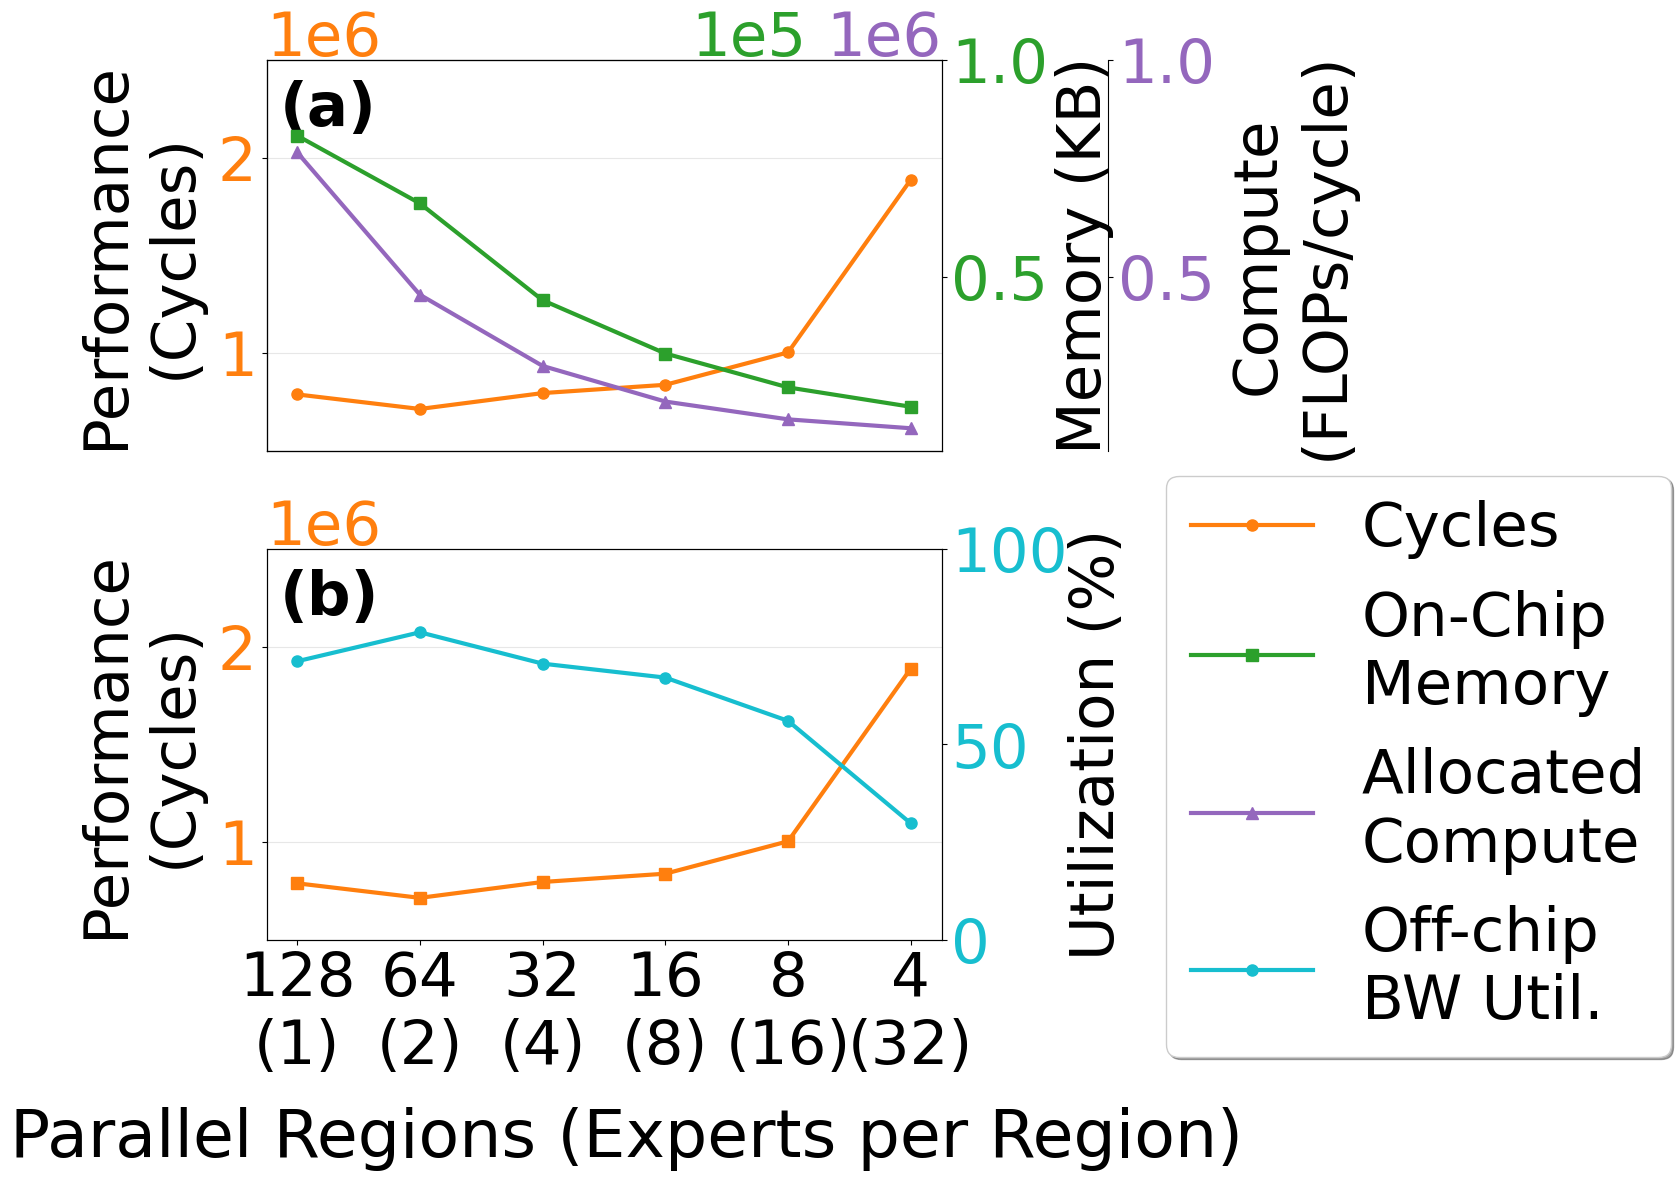

In [218]:
outfile = "./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_n32.pdf"

on_chip_scale=(1*1e4,10*1e4)
allocated_flops_scale=(1*1e5,10*1e5)
cycles_scale=(0.5*1e6,2.5*1e6)
bandwidth_scale_2=(0,100)

# on_chip_scale=None
# allocated_flops_scale=None
# cycles_scale=None
# bandwidth_scale_2=None


create_two_plots_pdf('./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_revet_128_4.csv',
    outfile,
    cycles_scale=cycles_scale, 
    on_chip_scale=on_chip_scale, 
    allocated_flops_scale=allocated_flops_scale, 
    bandwidth_scale_2=bandwidth_scale_2, 
    cycles_scale_2=cycles_scale)

# Overview / Thesis of the plot
* Claim to make:
    * Plot 1: x = n_par_region (8,16,32,64,128), y = (normalized compute util, flops allocated, on-chip-req)
        * In memory bound cases, timesharing can achieve similar performance with less compute and on-chip memory resource due to high utilization
    * Plot 2: x = n_par_region (all), y = (cycles, utilization)
        * Insight: However, allocating too little parallel region can cause worse compute utilization as the HBM bw utilization reduces due to the small parallelization factor in the memory bound application. Furthermore, when gathering expert weights per expert to do the computation as a gemm for better data reuse, making increasingly many experts share the same region (i.e., very small parallelization factor) can cause a high fan-out.

# Plot creation

## Plot 1: Timesharing increases utilization

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

def timeshare_utilization(csv_file, output_file=None, utilization_scale=None, on_chip_scale=None, allocated_flops_scale=None):
    """
    Create a multi-axis line chart from a single CSV file.
    
    Parameters:
    csv_file (str): Path to CSV file
    output_file (str, optional): Path to save the plot
    utilization_scale (tuple, optional): Y-axis scale for utilization
    on_chip_scale (tuple, optional): Y-axis scale for on-chip requirement
    allocated_flops_scale (tuple, optional): Y-axis scale for allocated FLOPS
    """
    axis_font = 40
    legend_font = 28
    tick_font = 32
    x_tick_size = 32
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    
    # Read CSV file
    df_combined = pd.read_csv(csv_file)
    
    # Create display names from n_par_region column
    display_names = df_combined['n_par_region'].astype(str).tolist()
    
    # Set up the plot with multiple y-axes
    fig, ax1 = plt.subplots(figsize=(11, 10))
    
    # Position of points on X axis
    x_pos = np.arange(len(display_names))
    
    baseline_utilization = df_combined['utilization(%)'].iloc[0]

    ax1.set_xlabel('Parallel Experts', fontsize=axis_font, fontweight='bold')
    
    # Create first y-axis for utilization
    line1 = ax1.plot(x_pos, df_combined['utilization(%)']/baseline_utilization, 
                     color=color_palette[0], marker='o', linewidth=3, 
                     markersize=8, label=f'Compute Util. (normalized)')
    
    # Customize first y-axis (for utilization)
    # ax1.set_ylabel('Compute Utilization', fontsize=axis_font, fontweight='bold', color=color_palette[0])
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(display_names, ha='center', fontsize=x_tick_size, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    # Remove scientific notation formatting for percentage values
    ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    
    # Create second y-axis for on_chip_requirement_bytes
    ax2 = ax1.twinx()
    line2 = ax2.plot(x_pos, df_combined['on_chip_requirement_bytes'] / 1000, 
                     color=color_palette[2], marker='s', linewidth=3, 
                     markersize=8, label='On-Chip Requirement (KB)')
    
    # Customize second y-axis (for on-chip requirement)
    # ax2.set_ylabel('On-Chip Memory (KB)', fontsize=axis_font, fontweight='bold', color=color_palette[2])
    ax2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_offset_text = ax2.yaxis.get_offset_text()
    ax2_offset_text.set_fontsize(tick_font)
    ax2_offset_text.set_position((0.89, 1.02))  # (x, y) in axis coordinates
    
    
    # Create third y-axis for allocated_flops
    ax3 = ax1.twinx()
    # Offset the third axis
    ax3.spines['right'].set_position(('outward', 75))
    
    # Create line plot for allocated_flops
    line = ax3.plot(x_pos, df_combined['allocated_flops'], 
                    color=color_palette[4], marker='^', linewidth=3, 
                    markersize=8, label=f'Allocated Comp. Resource \n(FLOPs/cycle)')
    
    
    # Customize third y-axis
    # ax3.set_ylabel('Allocated Compute (FLOPs/cycle)', fontsize=axis_font, fontweight='bold', color=color_palette[4])
    ax3.tick_params(axis='y', labelcolor=color_palette[4], labelsize=tick_font)
    ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax3_offset_text = ax3.yaxis.get_offset_text()
    ax3_offset_text.set_fontsize(tick_font)
    ax3_offset_text.set_position((1, 1.02))  # (x, y) in axis coordinates
    
    
    # ==================== Set Range ====================
    if utilization_scale is not None:
        ax1.set_ylim(utilization_scale) # utilization
    if on_chip_scale is not None:
        ax2.set_ylim(on_chip_scale) # on-chip requirement
    if allocated_flops_scale is not None:
        ax3.set_ylim(allocated_flops_scale) # allocated flops
    

        
    # Add value labels to line points
    # for i, (x, y) in enumerate(zip(x_pos, df_combined['utilization(%)'])):
    #     ax1.annotate(f'{y:.1f}%',
    #         xy=(x, y),
    #         xytext=(0, 10),
    #         textcoords="offset points",
    #         ha='center', va='bottom',
    #         fontsize=8, color=color_palette[0], fontweight='bold')
    
    # for i, (x, y) in enumerate(zip(x_pos, df_combined['on_chip_requirement_bytes'])):
    #     ax2.annotate(f'{y/1000:,.0f}',
    #         xy=(x, y/1000),
    #         xytext=(0, 10),
    #         textcoords="offset points",
    #         ha='center', va='bottom',
    #         fontsize=8, color=color_palette[2], fontweight='bold')
    
    # for i, (x, y) in enumerate(zip(x_pos, df_combined['allocated_flops'])):
    #     ax3.annotate(f'{y:,.0f}',
    #         xy=(x, y),
    #         xytext=(0, 10),
    #         textcoords="offset points",
    #         ha='center', va='bottom',
    #         fontsize=8, color=color_palette[4], fontweight='bold')
    
    
    # Combine legends from all axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    
    # Create a single legend with all elements
    all_handles = lines1 + lines2 + lines3
    all_labels = labels1 + labels2 + labels3
    ax1.legend(all_handles, all_labels, loc='upper right', fontsize=legend_font)
    
    # Add title and grid
    # plt.title('Memory Traffic and Cycles Analysis', fontsize=16, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save plot if output file specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")
    
    # Show plot
    plt.show()

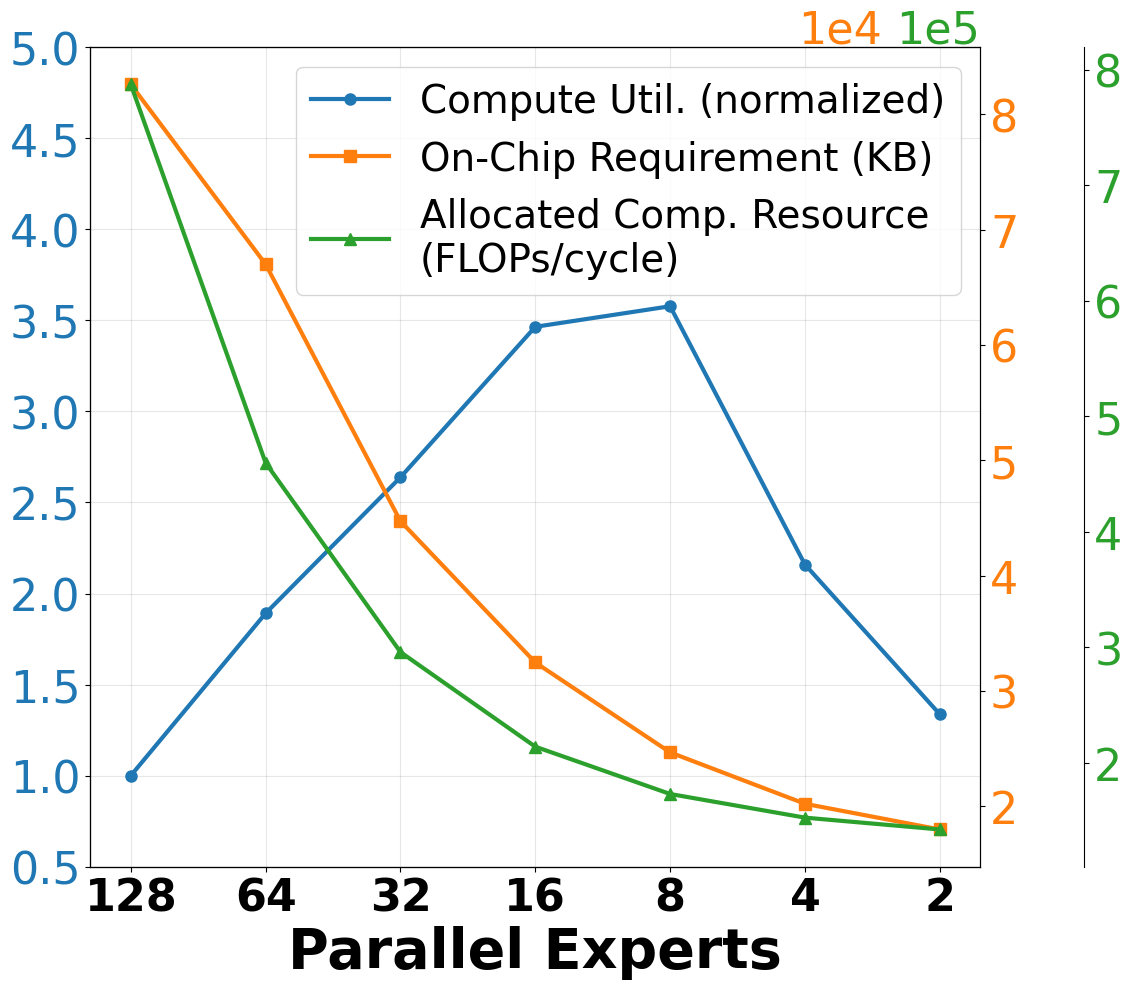

In [ ]:
csv_file = "./timeshare_mem_bound/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_revet_09042055.csv"
# output_file = "./timeshare_mem_bound/qwen_128_96_iter032_layer_012_n32_f48_timeshare_membound_revet.pdf"
output_file = None

utilization_scale = None
on_chip_scale = None
allocated_flops_scale = None

utilization_scale = (0.5,5) # off-chip traffic
# on_chip_scale = (0.2*1e4,1.3*1e4) # on-chip requirement
# allocated_flops_scale = (0,4*1e6) # cycles

timeshare_utilization(csv_file, output_file=output_file, utilization_scale=utilization_scale, on_chip_scale=on_chip_scale, allocated_flops_scale=allocated_flops_scale)

Plot saved to ./timeshare_mem_bound/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound.pdf


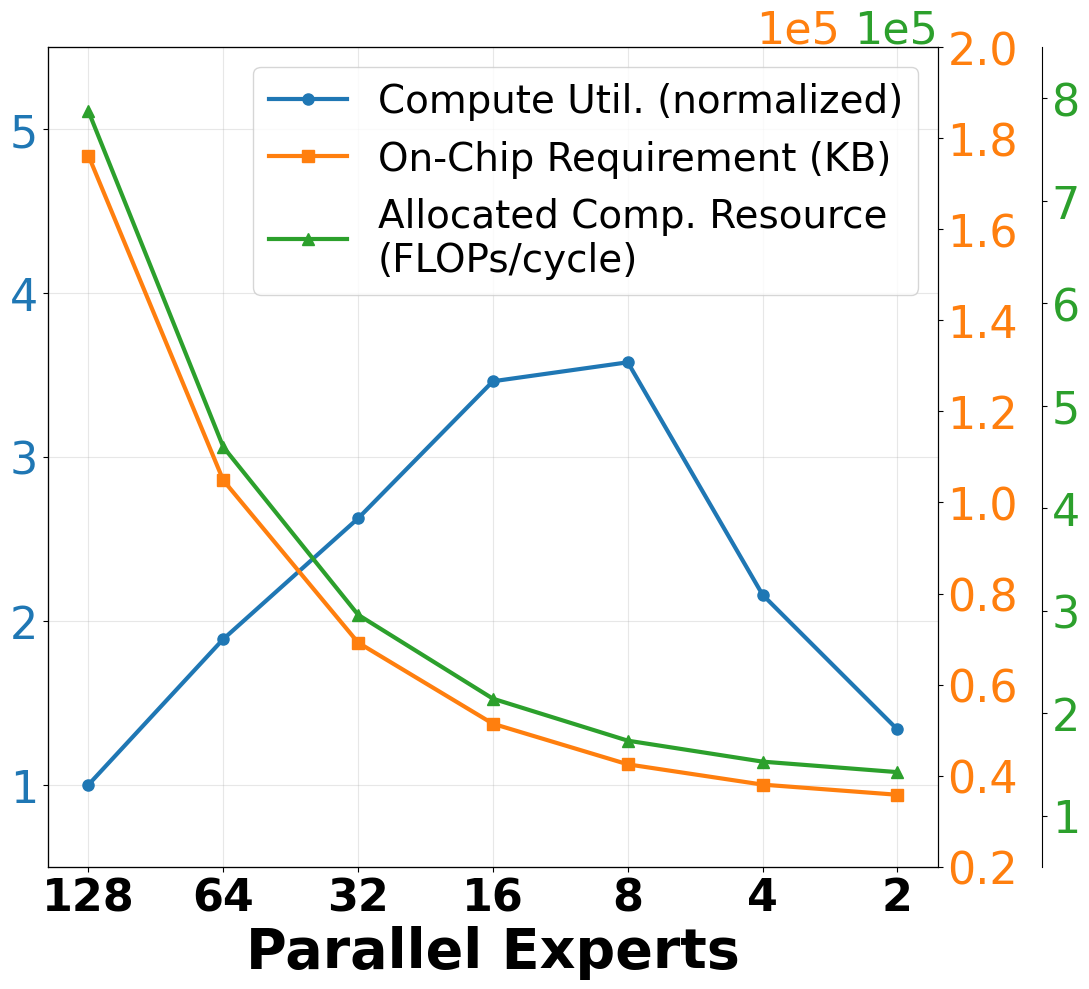

In [ ]:
csv_file = "./timeshare_mem_bound/combined_qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound.csv"
output_file = "./timeshare_mem_bound/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound.pdf"
# output_file = None

utilization_scale = None
on_chip_scale = None
allocated_flops_scale = None

utilization_scale = (0.5,5.5) # off-chip traffic
on_chip_scale = (0.2*1e5,2*1e5) # on-chip requirement
allocated_flops_scale = (0.5*1e5,8.5*1e5) # cycles

timeshare_utilization(csv_file, output_file=output_file, utilization_scale=utilization_scale, on_chip_scale=on_chip_scale, allocated_flops_scale=allocated_flops_scale)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

def timeshare_utilization_raw(csv_file, output_file=None, utilization_scale=None, on_chip_scale=None, allocated_flops_scale=None):
    """
    Create a multi-axis line chart from a single CSV file.
    
    Parameters:
    csv_file (str): Path to CSV file
    output_file (str, optional): Path to save the plot
    utilization_scale (tuple, optional): Y-axis scale for utilization
    on_chip_scale (tuple, optional): Y-axis scale for on-chip requirement
    allocated_flops_scale (tuple, optional): Y-axis scale for allocated FLOPS
    """
    axis_font = 40
    legend_font = 28
    tick_font = 32
    x_tick_size = 32
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    
    # Read CSV file
    df_combined = pd.read_csv(csv_file)
    
    # Create display names from n_par_region column
    display_names = df_combined['n_par_region'].tolist()
    display_names = [f'{name}\n({128 // name})' for name in display_names]
    
    # Set up the plot with multiple y-axes
    fig, ax1 = plt.subplots(figsize=(11, 10))
    
    # Position of points on X axis
    x_pos = np.arange(len(display_names))
    
    # baseline_utilization = df_combined['utilization(%)'].iloc[0]

    ax1.set_xlabel('Parallel Regions\n(Experts per Region)', fontsize=axis_font, fontweight='bold', labelpad=20)
    
    # Create first y-axis for utilization
    line1 = ax1.plot(x_pos, df_combined['utilization(%)'], 
                     color=color_palette[0], marker='o', linewidth=3, 
                     markersize=8, label=f'Compute Util. (%)')
    
    # Customize first y-axis (for utilization)
    # ax1.set_ylabel('Compute Utilization', fontsize=axis_font, fontweight='bold', color=color_palette[0])
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(display_names, ha='center', fontsize=x_tick_size, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    # Remove scientific notation formatting for percentage values
    ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    
    # Create second y-axis for on_chip_requirement_bytes
    ax2 = ax1.twinx()
    line2 = ax2.plot(x_pos, df_combined['on_chip_requirement_bytes'] / 1000, 
                     color=color_palette[2], marker='s', linewidth=3, 
                     markersize=8, label='On-Chip Requirement (KB)')
    
    # Customize second y-axis (for on-chip requirement)
    # ax2.set_ylabel('On-Chip Memory (KB)', fontsize=axis_font, fontweight='bold', color=color_palette[2])
    ax2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_offset_text = ax2.yaxis.get_offset_text()
    ax2_offset_text.set_fontsize(tick_font)
    ax2_offset_text.set_position((0.89, 1.02))  # (x, y) in axis coordinates
    
    
    # Create third y-axis for allocated_flops
    ax3 = ax1.twinx()
    # Offset the third axis
    ax3.spines['right'].set_position(('outward', 40))
    
    # Create line plot for allocated_flops
    line = ax3.plot(x_pos, df_combined['allocated_flops'], 
                    color=color_palette[4], marker='^', linewidth=3, 
                    markersize=8, label=f'Allocated Comp. Resource \n(FLOPs/cycle)')
    
    
    # Customize third y-axis
    # ax3.set_ylabel('Allocated Compute (FLOPs/cycle)', fontsize=axis_font, fontweight='bold', color=color_palette[4])
    ax3.tick_params(axis='y', labelcolor=color_palette[4], labelsize=tick_font)
    ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax3_offset_text = ax3.yaxis.get_offset_text()
    ax3_offset_text.set_fontsize(tick_font)
    ax3_offset_text.set_position((1, 1.02))  # (x, y) in axis coordinates
    
    
    # ==================== Set Range ====================
    if utilization_scale is not None:
        ax1.set_ylim(utilization_scale) # utilization
    if on_chip_scale is not None:
        ax2.set_ylim(on_chip_scale) # on-chip requirement
    if allocated_flops_scale is not None:
        ax3.set_ylim(allocated_flops_scale) # allocated flops
    

        
    # Add value labels to line points
    # for i, (x, y) in enumerate(zip(x_pos, df_combined['utilization(%)'])):
    #     ax1.annotate(f'{y:.1f}%',
    #         xy=(x, y),
    #         xytext=(0, 10),
    #         textcoords="offset points",
    #         ha='center', va='bottom',
    #         fontsize=8, color=color_palette[0], fontweight='bold')
    
    # for i, (x, y) in enumerate(zip(x_pos, df_combined['on_chip_requirement_bytes'])):
    #     ax2.annotate(f'{y/1000:,.0f}',
    #         xy=(x, y/1000),
    #         xytext=(0, 10),
    #         textcoords="offset points",
    #         ha='center', va='bottom',
    #         fontsize=8, color=color_palette[2], fontweight='bold')
    
    # for i, (x, y) in enumerate(zip(x_pos, df_combined['allocated_flops'])):
    #     ax3.annotate(f'{y:,.0f}',
    #         xy=(x, y),
    #         xytext=(0, 10),
    #         textcoords="offset points",
    #         ha='center', va='bottom',
    #         fontsize=8, color=color_palette[4], fontweight='bold')
    
    
    # Combine legends from all axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    
    # Create a single legend with all elements
    all_handles = lines1 + lines2 + lines3
    all_labels = labels1 + labels2 + labels3
    ax1.legend(all_handles, all_labels, loc='upper right', fontsize=legend_font)
    
    # Add title and grid
    # plt.title('Memory Traffic and Cycles Analysis', fontsize=16, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save plot if output file specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")
    
    # Show plot
    plt.show()

Plot saved to ./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_revet_raw_comp_util.pdf


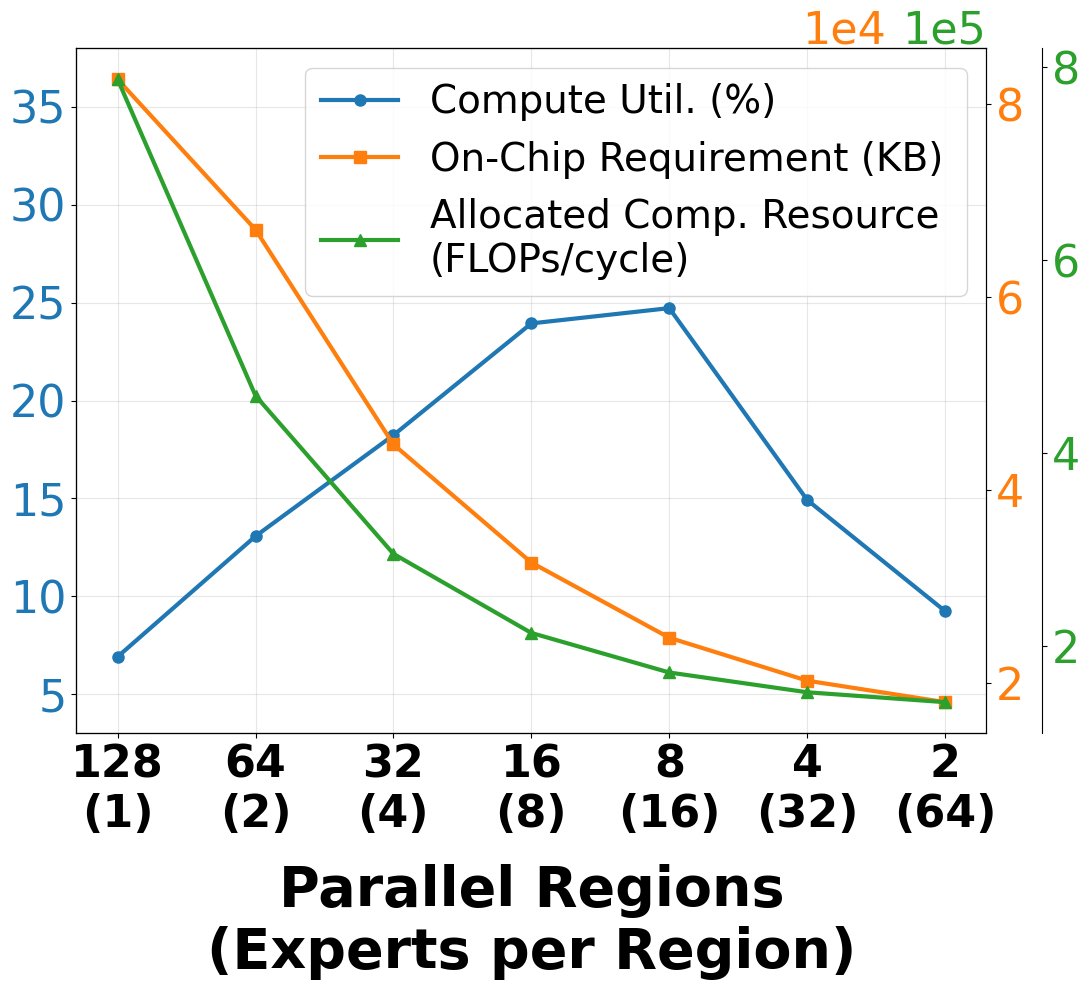

In [ ]:
csv_file = "./timeshare_mem_bound/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_revet_09042055.csv"
output_file = "./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_revet_raw_comp_util.pdf"
# output_file = None

utilization_scale = None
on_chip_scale = None
allocated_flops_scale = None

utilization_scale = (3,38)
# on_chip_scale = (0.2*1e5,2*1e5) 
# allocated_flops_scale = (0.5*1e5,8.5*1e5) 

timeshare_utilization_raw(csv_file, output_file=output_file, utilization_scale=utilization_scale, on_chip_scale=on_chip_scale, allocated_flops_scale=allocated_flops_scale)

## Plot 2: Finding the right expert sharing degree is important

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

def cycle_utilization(csv_file, output_file=None, utilization_scale=None, cycles_scale=None):
    """
    Create a multi-axis line chart from a single CSV file.
    
    Parameters:
    csv_file (str): Path to CSV file
    output_file (str, optional): Path to save the plot
    utilization_scale (tuple, optional): Y-axis scale for utilization
    cycles_scale (tuple, optional): Y-axis scale for cycles
    """
    axis_font = 40
    legend_font = 28
    tick_font = 32
    x_tick_size = 32
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    
    # Read CSV file
    df_combined = pd.read_csv(csv_file)
    
    # Create display names from n_par_region column
    display_names = df_combined['n_par_region'].astype(str).tolist()
    
    # Set up the plot with multiple y-axes
    fig, ax1 = plt.subplots(figsize=(11, 10))
    
    # Position of points on X axis
    x_pos = np.arange(len(display_names))
    
    baseline_utilization = df_combined['utilization(%)'].iloc[0]

    ax1.set_xlabel('Parallel Experts', fontsize=axis_font, fontweight='bold')
    
    # Create first y-axis for utilization
    line1 = ax1.plot(x_pos, df_combined['utilization(%)']/baseline_utilization, 
                     color=color_palette[0], marker='o', linewidth=3, 
                     markersize=8, label=f'Compute Util. (normalized)')
    
    # Customize first y-axis (for utilization)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(display_names, ha='center', fontsize=x_tick_size, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    
    # Create second y-axis for cycles
    ax2 = ax1.twinx()
    line2 = ax2.plot(x_pos, df_combined['cycles'], 
                     color=color_palette[2], marker='s', linewidth=3, 
                     markersize=8, label='Cycles')
    
    # Customize second y-axis (for cycles)
    ax2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_offset_text = ax2.yaxis.get_offset_text()
    ax2_offset_text.set_fontsize(tick_font)
    ax2_offset_text.set_position((0.99, 1.02))  # (x, y) in axis coordinates
    
    # ==================== Set Range ====================
    if utilization_scale is not None:
        ax1.set_ylim(utilization_scale) # utilization
    if cycles_scale is not None:
        ax2.set_ylim(cycles_scale) # cycles
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    # Create a single legend with all elements
    all_handles = lines1 + lines2
    all_labels = labels1 + labels2
    ax1.legend(all_handles, all_labels, loc='upper right', fontsize=legend_font)
    
    # Add grid
    ax1.grid(True, alpha=0.3)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save plot if output file specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")
    
    # Show plot
    plt.show()

Plot saved to ./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound.pdf


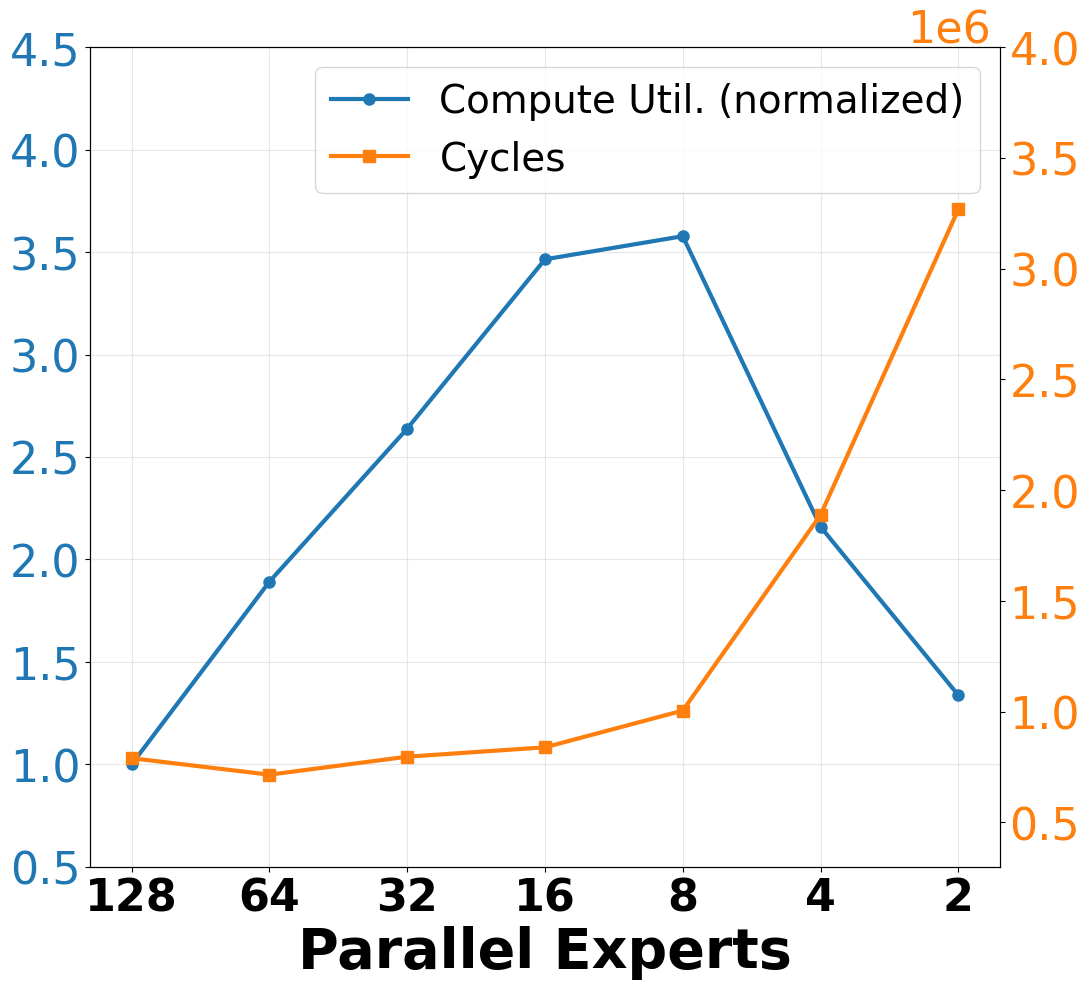

In [ ]:
csv_file = "./timeshare_mem_bound/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_revet_09042055.csv"
output_file = "./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound.pdf"
# output_file = None

utilization_scale = None
cycles_scale = None

utilization_scale = (0.5,4.5) # off-chip traffic
cycles_scale = (0.3*1e6,4*1e6) # cycles

cycle_utilization(csv_file, output_file=output_file, utilization_scale=utilization_scale, cycles_scale=cycles_scale)

Plot saved to ./timeshare_mem_bound/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_cycle_util.pdf


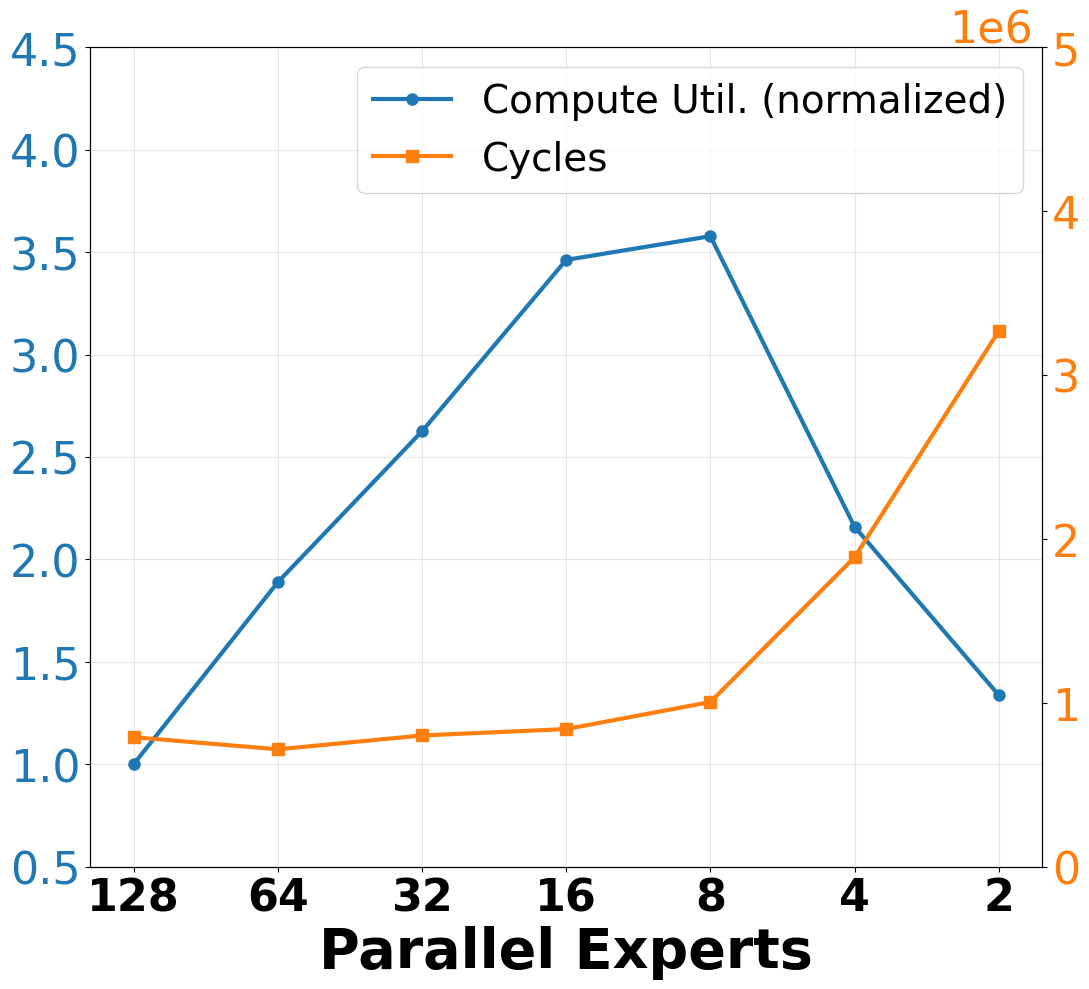

In [ ]:
csv_file = "./timeshare_mem_bound/combined_qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound.csv"
output_file = "./timeshare_mem_bound/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_cycle_util.pdf"
# output_file = None

utilization_scale = None
cycles_scale = None

utilization_scale = (0.5,4.5) # util
cycles_scale = (0*1e6,5*1e6) # cycles

cycle_utilization(csv_file, output_file=output_file, utilization_scale=utilization_scale, cycles_scale=cycles_scale)

## Plot 2.5: Compute utilization (Raw) & Cycles 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

def cycle_raw_comp_utilization(csv_file, output_file=None, utilization_scale=None, cycles_scale=None):
    """
    Create a multi-axis line chart from a single CSV file.
    
    Parameters:
    csv_file (str): Path to CSV file
    output_file (str, optional): Path to save the plot
    utilization_scale (tuple, optional): Y-axis scale for utilization
    cycles_scale (tuple, optional): Y-axis scale for cycles
    """
    axis_font = 40
    legend_font = 28
    tick_font = 32
    x_tick_size = 32
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    
    # Read CSV file
    df_combined = pd.read_csv(csv_file)
    
    # Create display names from n_par_region column
    display_names = df_combined['n_par_region'].tolist()
    display_names = [f'{name}\n({128 // name})' for name in display_names]

    # Set up the plot with multiple y-axes
    fig, ax1 = plt.subplots(figsize=(10, 10))
    
    # Position of points on X axis
    x_pos = np.arange(len(display_names))
    
    # baseline_utilization = df_combined['utilization(%)'].iloc[0]

    ax1.set_xlabel('Parallel Regions\n(Experts per Region)', fontsize=axis_font, labelpad=20)
    
    # Create first y-axis for utilization
    line1 = ax1.plot(x_pos, df_combined['utilization(%)'], 
                     color=color_palette[0], marker='o', linewidth=3, 
                     markersize=8, label=f'Compute Util. (%)')
    
    # Customize first y-axis (for utilization)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(display_names, ha='center', fontsize=x_tick_size)
    ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    
    # Create second y-axis for cycles
    ax2 = ax1.twinx()
    line2 = ax2.plot(x_pos, df_combined['cycles'], 
                     color=color_palette[2], marker='s', linewidth=3, 
                     markersize=8, label='Cycles')
    
    # Customize second y-axis (for cycles)
    ax2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_offset_text = ax2.yaxis.get_offset_text()
    ax2_offset_text.set_fontsize(tick_font)
    ax2_offset_text.set_position((0.99, 1.02))  # (x, y) in axis coordinates
    
    # ==================== Set Range ====================
    if utilization_scale is not None:
        ax1.set_ylim(utilization_scale) # utilization
    if cycles_scale is not None:
        ax2.set_ylim(cycles_scale) # cycles
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    # Create a single legend with all elements
    all_handles = lines1 + lines2
    all_labels = labels1 + labels2
    ax1.legend(all_handles, all_labels, loc='upper right', fontsize=legend_font)
    
    # Add grid
    ax1.grid(True, alpha=0.3)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save plot if output file specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")
    
    # Show plot
    plt.show()

Plot saved to ./timeshare_mem_bound/figure/qwen_iter032_layer_012_n32_f48_comp_util.pdf


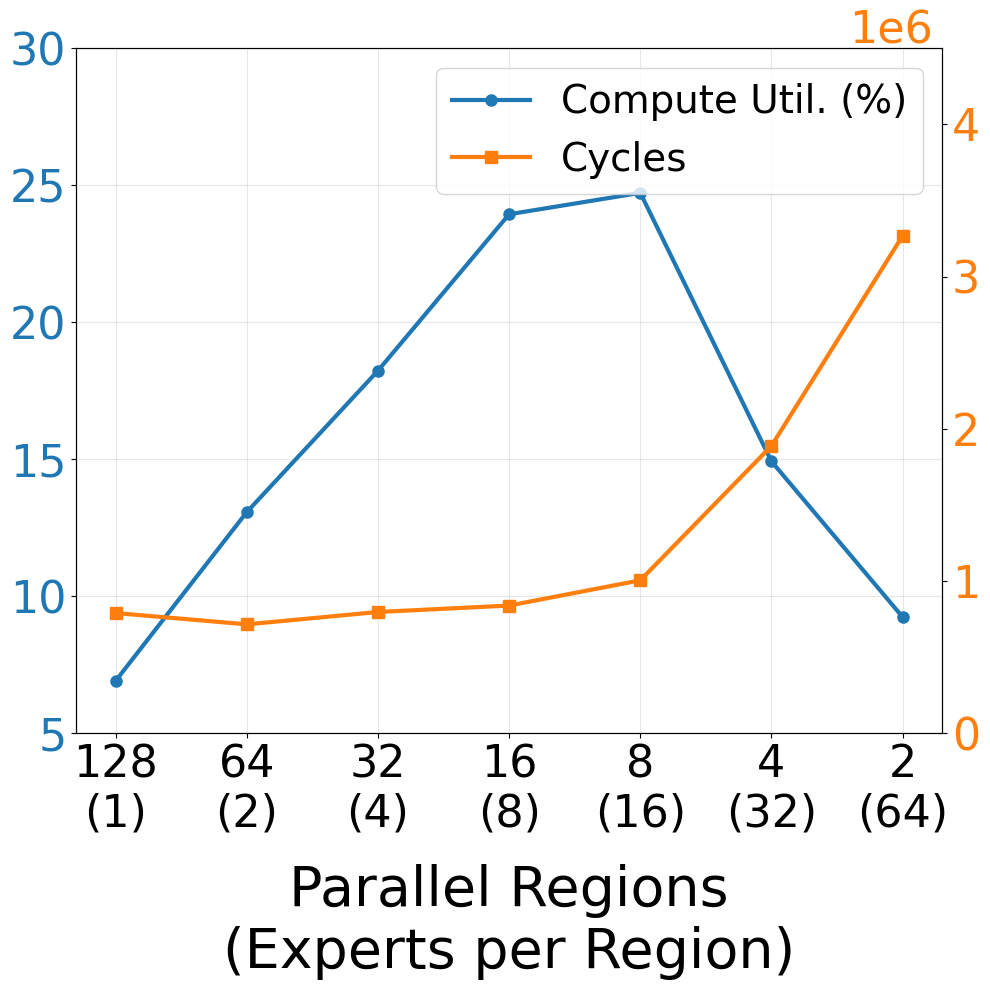

In [ ]:
csv_file = "./timeshare_mem_bound/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_revet_09042055.csv"
output_file = "./timeshare_mem_bound/figure/qwen_iter032_layer_012_n32_f48_comp_util.pdf"
# output_file = None

utilization_scale = None
cycles_scale = None

utilization_scale = (5,30) # util
cycles_scale = (0*1e6,4.5*1e6) # cycles

cycle_raw_comp_utilization(csv_file, output_file=output_file, utilization_scale=utilization_scale, cycles_scale=cycles_scale)

## Plot 3: Bandwidth utilization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

def cycle_raw_mem_utilization(csv_file, output_file=None, utilization_scale=None, cycles_scale=None):
    """
    Create a multi-axis line chart from a single CSV file.
    
    Parameters:
    csv_file (str): Path to CSV file
    output_file (str, optional): Path to save the plot
    utilization_scale (tuple, optional): Y-axis scale for utilization
    cycles_scale (tuple, optional): Y-axis scale for cycles
    """
    axis_font = 40
    legend_font = 28
    tick_font = 32
    x_tick_size = 32
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    
    # Read CSV file
    df_combined = pd.read_csv(csv_file)
    
    # Create display names from n_par_region column
    display_names = df_combined['n_par_region'].tolist()
    display_names = [f'{name}\n({128 // name})' for name in display_names]

    # Set up the plot with multiple y-axes
    fig, ax1 = plt.subplots(figsize=(10, 10))
    
    # Position of points on X axis
    x_pos = np.arange(len(display_names))
    
    # baseline_utilization = df_combined['utilization(%)'].iloc[0]
    mem_bw = 1024 # (bytes/cycle)

    ax1.set_xlabel('Parallel Regions\n(Experts per Region)', fontsize=axis_font,labelpad=20)
    
    # Create first y-axis for utilization
    line1 = ax1.plot(x_pos, (df_combined['off_chip_traffic_bytes']/df_combined['cycles'])/mem_bw*100, 
                     color=color_palette[0], marker='o', linewidth=3, 
                     markersize=8, label=f'Off-chip Bandwidth Util. (%)')
    
    # Customize first y-axis (for utilization)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(display_names, ha='center', fontsize=x_tick_size)
    ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    
    # Create second y-axis for cycles
    ax2 = ax1.twinx()
    line2 = ax2.plot(x_pos, df_combined['cycles'], 
                     color=color_palette[2], marker='s', linewidth=3, 
                     markersize=8, label='Cycles')
    
    # Customize second y-axis (for cycles)
    ax2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_offset_text = ax2.yaxis.get_offset_text()
    ax2_offset_text.set_fontsize(tick_font)
    ax2_offset_text.set_position((0.99, 1.02))  # (x, y) in axis coordinates
    
    # ==================== Set Range ====================
    if utilization_scale is not None:
        ax1.set_ylim(utilization_scale) # utilization
    if cycles_scale is not None:
        ax2.set_ylim(cycles_scale) # cycles
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    # Create a single legend with all elements
    all_handles = lines1 + lines2
    all_labels = labels1 + labels2
    ax1.legend(all_handles, all_labels, loc='upper right', fontsize=legend_font)
    
    # Add grid
    ax1.grid(True, alpha=0.3)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save plot if output file specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")
    
    # Show plot
    plt.show()

Plot saved to ./timeshare_mem_bound/figure/qwen_iter032_layer_012_n32_f48_bw_util.pdf


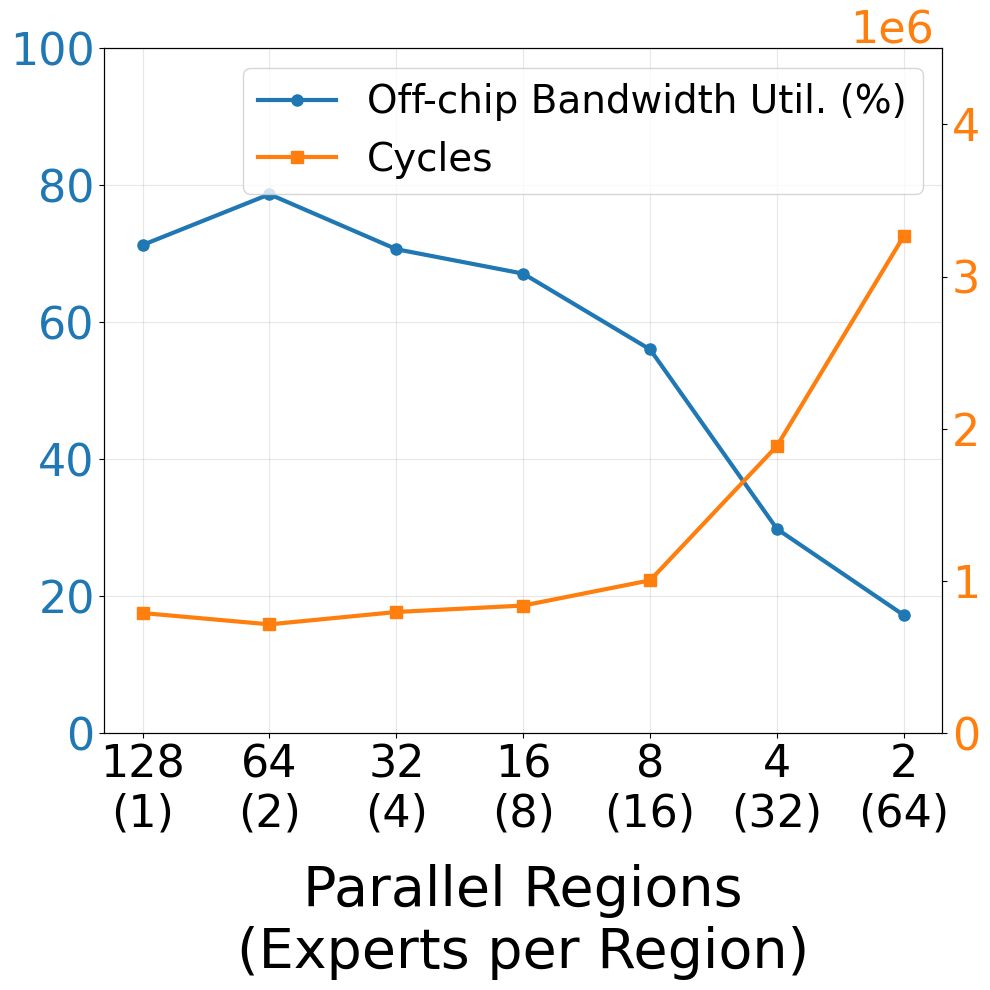

In [ ]:
csv_file = "./timeshare_mem_bound/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_revet_09042055.csv"
output_file = "./timeshare_mem_bound/figure/qwen_iter032_layer_012_n32_f48_bw_util.pdf"
# output_file = None

utilization_scale = None
cycles_scale = None

utilization_scale = (0,100) # util
cycles_scale = (0*1e6,4.5*1e6) # cycles

cycle_raw_mem_utilization(csv_file, output_file=output_file, utilization_scale=utilization_scale, cycles_scale=cycles_scale)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

def create_three_plots_pdf(csv_file, output_pdf, utilization_scale=None, on_chip_scale=None, 
                           allocated_flops_scale=None, cycles_scale=None, bandwidth_scale=None,
                           cycles_scale_2=None, bandwidth_scale_2=None):
    """
    Create a single PDF with three plots having equal box sizes.
    
    Parameters:
    csv_file (str): Path to CSV file
    output_pdf (str): Path to save the PDF
    utilization_scale (tuple, optional): Y-axis scale for compute utilization
    on_chip_scale (tuple, optional): Y-axis scale for on-chip requirement
    allocated_flops_scale (tuple, optional): Y-axis scale for allocated FLOPS
    cycles_scale (tuple, optional): Y-axis scale for cycles (plot 2)
    bandwidth_scale (tuple, optional): Y-axis scale for bandwidth utilization (plot 2)
    cycles_scale_2 (tuple, optional): Y-axis scale for cycles (plot 3)
    bandwidth_scale_2 (tuple, optional): Y-axis scale for bandwidth utilization (plot 3)
    """
    
    axis_font = 32
    legend_font = 30
    tick_font = 26
    x_tick_size = 38
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    
    # Read CSV file
    df_combined = pd.read_csv(csv_file)
    
    # Create display names from n_par_region column
    display_names = df_combined['n_par_region'].tolist()
    display_names = [f'{name}\n({128 // name})' for name in display_names]
    
    # Position of points on X axis
    x_pos = np.arange(len(display_names))
    
    # Create figure with subplots - adjusted for three plots
    fig = plt.figure(figsize=(30, 10))
    
    # Use gridspec for better control over subplot positioning
    from matplotlib.gridspec import GridSpec
    gs = GridSpec(1, 3, figure=fig, left=0.05, right=0.88, bottom=0.2, wspace=0.3)
    
    # ==================== FIRST SUBPLOT: Three-axis plot ====================
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Create first y-axis for utilization
    line1 = ax1.plot(x_pos, df_combined['utilization(%)'], 
                     color=color_palette[0], marker='o', linewidth=3, 
                     markersize=8, label=f'Compute Util. (%)')
    
    # Customize first y-axis
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(display_names, ha='center', fontsize=x_tick_size, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    
    # Create second y-axis for on_chip_requirement_bytes
    ax1_2 = ax1.twinx()
    line2 = ax1_2.plot(x_pos, df_combined['on_chip_requirement_bytes'] / 1000, 
                       color=color_palette[2], marker='s', linewidth=3, 
                       markersize=8, label='On-Chip Mem. (KB)')
    
    # Customize second y-axis
    ax1_2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
    ax1_2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax1_2_offset_text = ax1_2.yaxis.get_offset_text()
    ax1_2_offset_text.set_fontsize(tick_font-4)
    ax1_2_offset_text.set_position((0.89, 1.02))
    
    # Create third y-axis for allocated_flops
    ax1_3 = ax1.twinx()
    ax1_3.spines['right'].set_position(('outward', 50))
    
    line3 = ax1_3.plot(x_pos, df_combined['allocated_flops'], 
                       color=color_palette[4], marker='^', linewidth=3, 
                       markersize=8, label=f'Allocated Comp. \n(FLOPs/cycle)')
    
    # Customize third y-axis
    ax1_3.tick_params(axis='y', labelcolor=color_palette[4], labelsize=tick_font)
    ax1_3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax1_3_offset_text = ax1_3.yaxis.get_offset_text()
    ax1_3_offset_text.set_fontsize(tick_font-4)
    ax1_3_offset_text.set_position((1, 1.02))
    
    # Set scales for first plot
    if utilization_scale is not None:
        ax1.set_ylim(utilization_scale)
    if on_chip_scale is not None:
        ax1_2.set_ylim(on_chip_scale)
    if allocated_flops_scale is not None:
        ax1_3.set_ylim(allocated_flops_scale)
    
    # Combine legends for first plot
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_2.get_legend_handles_labels()
    lines3, labels3 = ax1_3.get_legend_handles_labels()
    all_handles1 = lines1 + lines2 + lines3
    all_labels1 = labels1 + labels2 + labels3
    ax1.legend(all_handles1, all_labels1, loc='upper right', fontsize=legend_font)
    
    ax1.grid(True, alpha=0.3)
    # ax1.set_title('Plot 1: Utilization & Resources', fontsize=axis_font, fontweight='bold', pad=20)
    
    # ==================== SECOND SUBPLOT: Two-axis plot ====================
    ax2 = fig.add_subplot(gs[0, 1])
    
    mem_bw = 1024  # (bytes/cycle)
    
    # Create first y-axis for bandwidth utilization
    line4 = ax2.plot(x_pos, df_combined['utilization(%)'], 
                     color=color_palette[0], marker='o', linewidth=3, 
                     markersize=8, label=f'Compute Util. (%)')
    
    # Customize first y-axis
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(display_names, ha='center', fontsize=x_tick_size, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    
    # Create second y-axis for cycles
    ax2_2 = ax2.twinx()
    line5 = ax2_2.plot(x_pos, df_combined['cycles'], 
                       color=color_palette[2], marker='s', linewidth=3, 
                       markersize=8, label='Cycles')
    
    # Customize second y-axis
    ax2_2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
    ax2_2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_2_offset_text = ax2_2.yaxis.get_offset_text()
    ax2_2_offset_text.set_fontsize(tick_font)
    ax2_2_offset_text.set_position((0.99, 1.02))
    
    # Set scales for second plot
    if bandwidth_scale is not None:
        ax2.set_ylim(bandwidth_scale)
    if cycles_scale is not None:
        ax2_2.set_ylim(cycles_scale)
    
    # Combine legends for second plot
    lines4, labels4 = ax2.get_legend_handles_labels()
    lines5, labels5 = ax2_2.get_legend_handles_labels()
    all_handles2 = lines4 + lines5
    all_labels2 = labels4 + labels5
    ax2.legend(all_handles2, all_labels2, loc='upper right', fontsize=legend_font)
    
    ax2.grid(True, alpha=0.3)
    # ax2.set_title('Plot 2: Bandwidth & Cycles', fontsize=axis_font, fontweight='bold', pad=20)
    
    # ==================== THIRD SUBPLOT: Your new plot ====================
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Create first y-axis for bandwidth utilization
    line6 = ax3.plot(x_pos, (df_combined['off_chip_traffic_bytes']/df_combined['cycles'])/mem_bw*100, 
                     color=color_palette[0], marker='o', linewidth=3, 
                     markersize=8, label=f'Off-chip BW Util. (%)')
    
    # Customize first y-axis
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(display_names, ha='center', fontsize=x_tick_size, fontweight='bold')
    ax3.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    
    # Create second y-axis for cycles
    ax3_2 = ax3.twinx()
    line7 = ax3_2.plot(x_pos, df_combined['cycles'], 
                       color=color_palette[2], marker='s', linewidth=3, 
                       markersize=8, label='Cycles')
    
    # Customize second y-axis
    ax3_2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
    ax3_2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax3_2_offset_text = ax3_2.yaxis.get_offset_text()
    ax3_2_offset_text.set_fontsize(tick_font)
    ax3_2_offset_text.set_position((0.99, 1.02))
    
    # Set scales for third plot
    if bandwidth_scale_2 is not None:
        ax3.set_ylim(bandwidth_scale_2)
    if cycles_scale_2 is not None:
        ax3_2.set_ylim(cycles_scale_2)
    
    # Combine legends for third plot
    lines6, labels6 = ax3.get_legend_handles_labels()
    lines7, labels7 = ax3_2.get_legend_handles_labels()
    all_handles3 = lines6 + lines7
    all_labels3 = labels6 + labels7
    ax3.legend(all_handles3, all_labels3, loc='upper right', fontsize=legend_font)
    
    ax3.grid(True, alpha=0.3)
    # ax3.set_title('Plot 3: Memory & Performance', fontsize=axis_font, fontweight='bold', pad=20)
    
    # Add shared x-axis label
    fig.text(0.465,-0.04, 'Parallel Regions (Experts per Region)', 
             fontsize=x_tick_size+4, fontweight='bold', ha='center', va='bottom')
    
    # Save to PDF
    # with PdfPages(output_pdf) as pdf:
    #     pdf.savefig(fig, bbox_inches='tight', dpi=300)
    #     print(f"Three plots saved to {output_pdf}")
    
    # Show the plot
    plt.show()
    plt.close()

# Example usage:
# create_three_plots_pdf('your_data.csv', 'three_plots.pdf')

In [93]:
outfile = "./timeshare_mem_bound/figure/qwen_iter032_layer_012_n32_f48_config.pdf"

utilization_scale=(3,40)
on_chip_scale=(1*1e4,10*1e4)
allocated_flops_scale=(1*1e5,10*1e5)
 
cycles_scale=(0.5*1e6,2.5*1e6)
bandwidth_scale=(3,40)

cycles_scale_2=(0.5*1e6,2.5*1e6) # cycles
bandwidth_scale_2=(0,100)


create_three_plots_pdf('./timeshare_mem_bound/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_revet_128_4.csv',
    outfile,
    utilization_scale=utilization_scale, 
    on_chip_scale=on_chip_scale, 
    allocated_flops_scale=allocated_flops_scale, 
    cycles_scale=cycles_scale, 
    bandwidth_scale=bandwidth_scale, 
    cycles_scale_2=cycles_scale_2, 
    bandwidth_scale_2=bandwidth_scale_2)

FileNotFoundError: [Errno 2] No such file or directory: './timeshare_mem_bound/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_revet_128_4.csv'

## Two plot version

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

def create_two_plots_pdf(csv_file, output_pdf, cycles_scale=None, on_chip_scale=None, 
                         allocated_flops_scale=None, bandwidth_scale_2=None, cycles_scale_2=None):
    """
    Create a single PDF with two plots having equal box sizes.
    
    Parameters:
    csv_file (str): Path to CSV file
    output_pdf (str): Path to save the PDF
    cycles_scale (tuple, optional): Y-axis scale for cycles (plot 1)
    on_chip_scale (tuple, optional): Y-axis scale for on-chip requirement
    allocated_flops_scale (tuple, optional): Y-axis scale for allocated FLOPS
    bandwidth_scale_2 (tuple, optional): Y-axis scale for bandwidth utilization (plot 2)
    cycles_scale_2 (tuple, optional): Y-axis scale for cycles (plot 2)
    """

    cycles_color_idx = 2
    on_chip_color_idx = 4
    allocated_flops_color_idx = 8
    bandwidth_color_idx = 18
    
    font_uniform = 36
    axis_font = font_uniform
    legend_font = font_uniform
    tick_font = font_uniform
    x_tick_size = font_uniform
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    print(color_palette)
    
    # Read CSV file
    df_combined = pd.read_csv(csv_file)
    
    # Create display names from n_par_region column
    display_names = df_combined['n_par_region'].tolist()
    display_names = [f'{name}\n({128 // name})' for name in display_names]
    
    # Position of points on X axis
    x_pos = np.arange(len(display_names))
    
    # Create figure with subplots - adjusted for two plots
    fig = plt.figure(figsize=(20, 8.5))
    
    # Use gridspec for better control over subplot positioning
    from matplotlib.gridspec import GridSpec
    gs = GridSpec(1, 2, figure=fig, left=0.05, right=0.88, bottom=0.2, wspace=0.8)
    
    # ==================== FIRST SUBPLOT: Three-axis plot ====================
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Create first y-axis for cycles
    line1 = ax1.plot(x_pos, df_combined['cycles'], 
                     color=color_palette[cycles_color_idx], marker='o', linewidth=3, 
                     markersize=8, label=f'Cycles')
    
    # Customize first y-axis
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(display_names, ha='center', fontsize=x_tick_size)
    ax1.tick_params(axis='y', labelcolor=color_palette[cycles_color_idx], labelsize=tick_font)
    # for label in ax1.get_yticklabels():
    #     label.set_fontweight('bold')
    ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax1_offset_text = ax1.yaxis.get_offset_text()
    ax1_offset_text.set_fontsize(tick_font-4)
    ax1_offset_text.set_position((-0.1, 1.02))
    ax1.set_ylabel('Performance (Cycles)', fontsize=axis_font,labelpad=10)
    
    # Create second y-axis for on_chip_requirement_bytes
    ax1_2 = ax1.twinx()
    line2 = ax1_2.plot(x_pos, df_combined['on_chip_requirement_bytes'] / 1000, 
                       color=color_palette[on_chip_color_idx], marker='s', linewidth=3, 
                       markersize=8, label='On-Chip Mem.')
    
    # Customize second y-axis
    ax1_2.tick_params(axis='y', labelcolor=color_palette[on_chip_color_idx], labelsize=tick_font)
    # for label in ax1_2.get_yticklabels():
    #     label.set_fontweight('bold')
    ax1_2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax1_2_offset_text = ax1_2.yaxis.get_offset_text()
    ax1_2_offset_text.set_fontsize(tick_font-4)
    ax1_2_offset_text.set_position((0.89, 1.02))
    
    ax1_2.set_ylabel('On-Chip Memory (KB)', fontsize=axis_font,labelpad=5)
    
    # Create third y-axis for allocated_flops
    ax1_3 = ax1.twinx()
    ax1_3.spines['right'].set_position(('outward', 120))
    
    line3 = ax1_3.plot(x_pos, df_combined['allocated_flops'], 
                       color=color_palette[allocated_flops_color_idx], marker='^', linewidth=3, 
                       markersize=8, label=f'Allocated Comp.')
    
    # Customize third y-axis
    ax1_3.tick_params(axis='y', labelcolor=color_palette[allocated_flops_color_idx], labelsize=tick_font)
    # for label in ax1_3.get_yticklabels():
    #     label.set_fontweight('bold')
    ax1_3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax1_3_offset_text = ax1_3.yaxis.get_offset_text()
    ax1_3_offset_text.set_fontsize(tick_font-4)
    ax1_3_offset_text.set_position((1, 1.02))
    ax1_3.set_ylabel('Compute BW (FLOPs/cycle)', fontsize=axis_font,labelpad=10)
    
    # Set scales for first plot
    if cycles_scale is not None:
        ax1.set_ylim(cycles_scale)
    if on_chip_scale is not None:
        ax1_2.set_ylim(on_chip_scale)
    if allocated_flops_scale is not None:
        ax1_3.set_ylim(allocated_flops_scale)
    
    # Combine legends for first plot
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_2.get_legend_handles_labels()
    lines3, labels3 = ax1_3.get_legend_handles_labels()
    all_handles1 = lines1 + lines2 + lines3
    all_labels1 = labels1 + labels2 + labels3
    ax1.legend(all_handles1, all_labels1, loc='upper right', fontsize=legend_font)
    
    ax1.grid(True, alpha=0.3)
    ax1.set_xlabel('(a)', fontsize=x_tick_size, fontweight='bold', labelpad=10)
    
    # ==================== SECOND SUBPLOT: Off-chip bandwidth plot ====================
    ax2 = fig.add_subplot(gs[0, 1])
    
    mem_bw = 1024  # (bytes/cycle)
    
    # Create first y-axis for bandwidth utilization
    line4 = ax2.plot(x_pos, (df_combined['off_chip_traffic_bytes']/df_combined['cycles'])/mem_bw*100, 
                     color=color_palette[bandwidth_color_idx], marker='o', linewidth=3, 
                     markersize=8, label=f'Off-chip BW Util.')
    
    # Customize first y-axis
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(display_names, ha='center', fontsize=x_tick_size)
    ax2.tick_params(axis='y', labelcolor=color_palette[bandwidth_color_idx], labelsize=tick_font)
    # for label in ax2.get_yticklabels():
    #     label.set_fontweight('bold')
    ax2.set_ylabel('Utilization (%)', fontsize=axis_font,labelpad=0)
    
    # Create second y-axis for cycles
    ax2_2 = ax2.twinx()
    line5 = ax2_2.plot(x_pos, df_combined['cycles'], 
                       color=color_palette[cycles_color_idx], marker='s', linewidth=3, 
                       markersize=8, label='Cycles')
    
    # Customize second y-axis
    ax2_2.tick_params(axis='y', labelcolor=color_palette[cycles_color_idx], labelsize=tick_font)
    # for label in ax2_2.get_yticklabels():
    #     label.set_fontweight('bold')
    ax2_2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_2_offset_text = ax2_2.yaxis.get_offset_text()
    ax2_2_offset_text.set_fontsize(tick_font)
    ax2_2_offset_text.set_position((0.99, 1.02))
    ax2_2.set_ylabel('Performance (Cycles)', fontsize=axis_font,labelpad=10)
    
    
    # Set scales for second plot
    if bandwidth_scale_2 is not None:
        ax2.set_ylim(bandwidth_scale_2)
    if cycles_scale_2 is not None:
        ax2_2.set_ylim(cycles_scale_2)
    
    # Combine legends for second plot
    lines4, labels4 = ax2.get_legend_handles_labels()
    lines5, labels5 = ax2_2.get_legend_handles_labels()
    all_handles2 = lines4 + lines5
    all_labels2 = labels4 + labels5
    ax2.legend(all_handles2, all_labels2, loc='upper right', fontsize=legend_font)
    
    ax2.grid(True, alpha=0.3)
    ax2.set_xlabel('(b)', fontsize=x_tick_size, fontweight='bold', labelpad=10)
    # ax2.set_title('Plot 2: Memory & Performance', fontsize=axis_font, fontweight='bold', pad=20)
    
    # Add shared x-axis label
    fig.text(0.465, -0.12, 'Parallel Regions (Experts per Region)', 
             fontsize=x_tick_size+4, ha='center', va='bottom')
    
    # Save to PDF
    with PdfPages(output_pdf) as pdf:
        pdf.savefig(fig, bbox_inches='tight', dpi=300)
        print(f"Two plots saved to {output_pdf}")
    
    # Show the plot
    plt.show()
    plt.close()

# Example usage:
# create_two_plots_pdf('your_data.csv', 'two_plots.pdf')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), (1.0, 0.4980392156862745, 0.054901960784313725), (1.0, 0.7333333333333333, 0.47058823529411764), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.596078431372549, 0.8745098039215686, 0.5411764705882353), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (1.0, 0.596078431372549, 0.5882352941176471), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.7725490196078432, 0.6901960784313725, 0.8352941176470589), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.7686274509803922, 0.611764705882353, 0.5803921568627451), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.9686274509803922, 0.7137254901960784, 0.8235294117647058), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7803921568627451, 0.7803921568627451, 0.7803921568627451), (0.7372549019607844, 0.7411764705882353, 0.1333

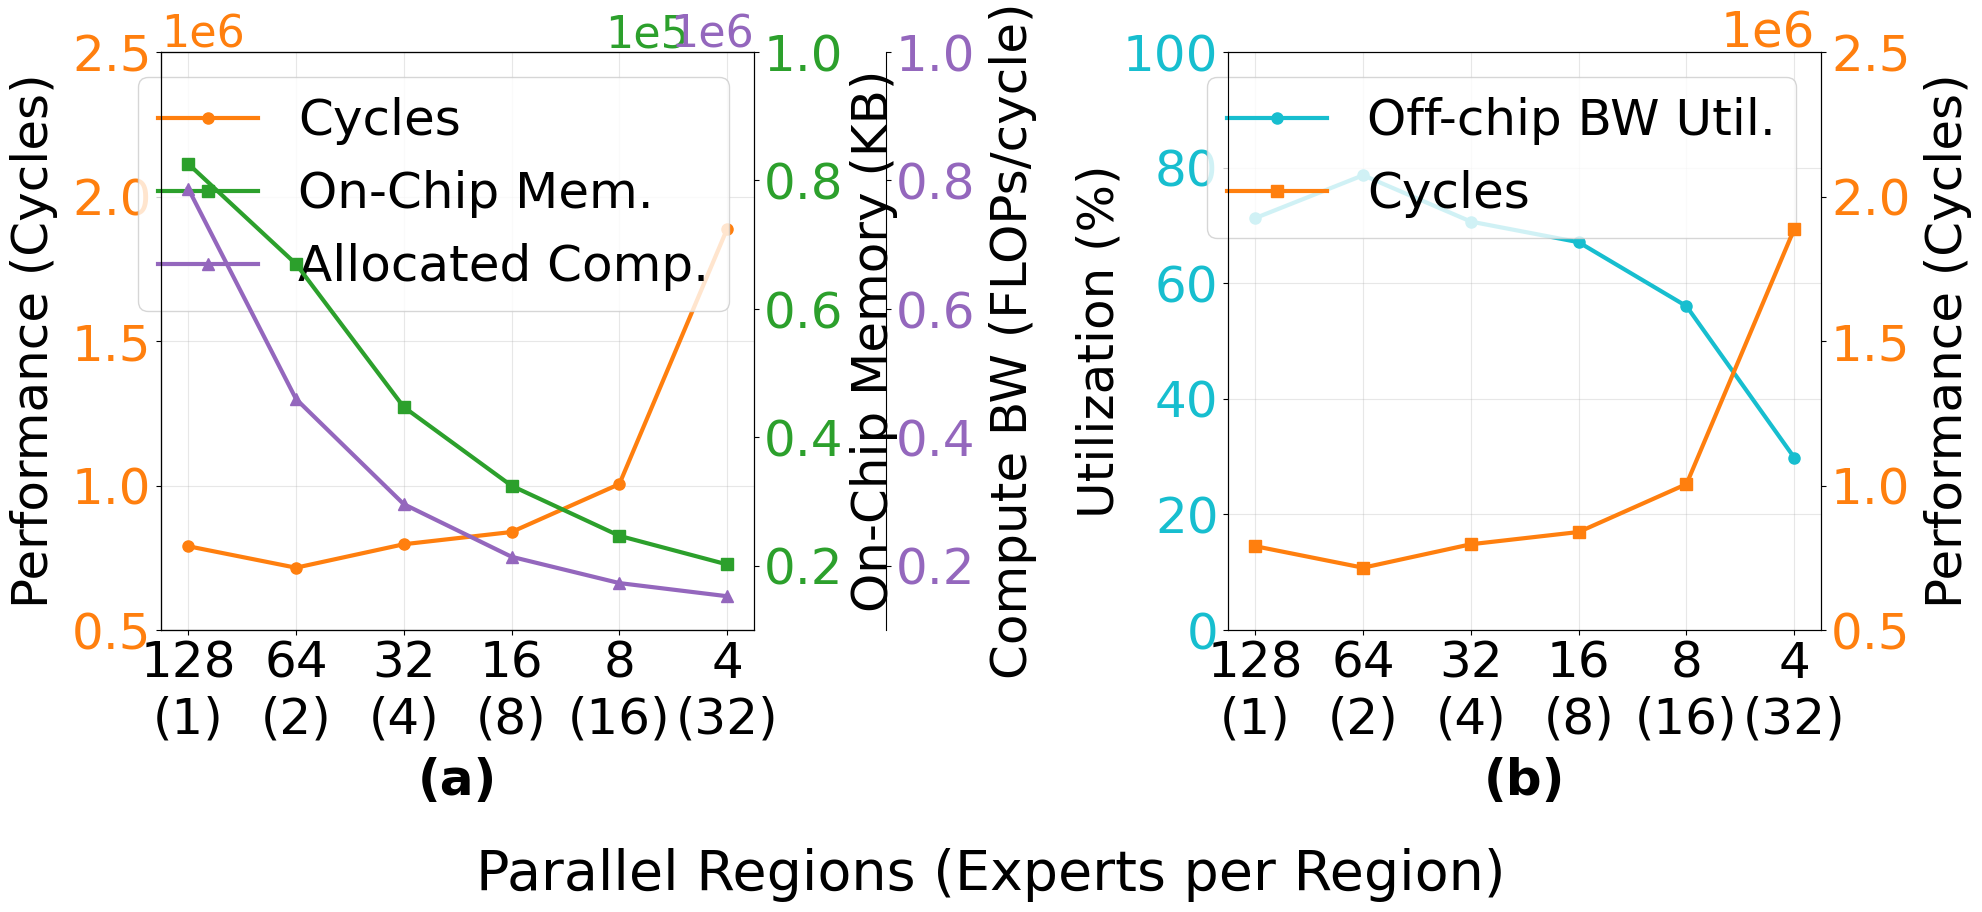

In [ ]:
outfile = "./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_n32.pdf"

on_chip_scale=(1*1e4,10*1e4)
allocated_flops_scale=(1*1e5,10*1e5)
cycles_scale=(0.5*1e6,2.5*1e6)
bandwidth_scale_2=(0,100)

# on_chip_scale=None
# allocated_flops_scale=None
# cycles_scale=None
# bandwidth_scale_2=None


create_two_plots_pdf('./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_revet_128_4.csv',
    outfile,
    cycles_scale=cycles_scale, 
    on_chip_scale=on_chip_scale, 
    allocated_flops_scale=allocated_flops_scale, 
    bandwidth_scale_2=bandwidth_scale_2, 
    cycles_scale_2=cycles_scale)

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

def create_two_csv_plots_pdf(csv_file_1, csv_file_2, output_pdf, 
                             utilization_scale_1=None, cycles_scale_1=None,
                             utilization_scale_2=None, cycles_scale_2=None):
    """
    Create a single PDF with two plots from different CSV files, each showing utilization and cycles.
    
    Parameters:
    csv_file_1 (str): Path to first CSV file
    csv_file_2 (str): Path to second CSV file
    output_pdf (str): Path to save the PDF
    utilization_scale_1 (tuple, optional): Y-axis scale for compute utilization (plot 1)
    cycles_scale_1 (tuple, optional): Y-axis scale for cycles (plot 1)
    utilization_scale_2 (tuple, optional): Y-axis scale for compute utilization (plot 2)
    cycles_scale_2 (tuple, optional): Y-axis scale for cycles (plot 2)
    """
    
    axis_font = 32
    legend_font = 30
    tick_font = 26
    x_tick_size = 38
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    
    # Read CSV files
    df_1 = pd.read_csv(csv_file_1)
    df_2 = pd.read_csv(csv_file_2)
    
    # Create display names from n_par_region column for both datasets
    display_names_1 = df_1['n_par_region'].tolist()
    display_names_1 = [f'{name}\n({128 // name})' for name in display_names_1]
    
    display_names_2 = df_2['n_par_region'].tolist()
    display_names_2 = [f'{name}\n({128 // name})' for name in display_names_2]
    
    # Position of points on X axis
    x_pos_1 = np.arange(len(display_names_1))
    x_pos_2 = np.arange(len(display_names_2))
    
    # Create figure with subplots - adjusted for two plots
    fig = plt.figure(figsize=(20, 8.5))
    
    # Use gridspec for better control over subplot positioning
    from matplotlib.gridspec import GridSpec
    gs = GridSpec(1, 2, figure=fig, left=0.05, right=0.88, bottom=0.2, wspace=0.4)
    
    # ==================== FIRST SUBPLOT: CSV File 1 ====================
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Create first y-axis for utilization
    line1 = ax1.plot(x_pos_1, df_1['utilization(%)'], 
                     color=color_palette[0], marker='o', linewidth=3, 
                     markersize=8, label=f'Compute Util. (%)')
    
    # Customize first y-axis
    ax1.set_xticks(x_pos_1)
    ax1.set_xticklabels(display_names_1, ha='center', fontsize=x_tick_size, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    
    # Create second y-axis for cycles
    ax1_2 = ax1.twinx()
    line2 = ax1_2.plot(x_pos_1, df_1['cycles'], 
                       color=color_palette[2], marker='s', linewidth=3, 
                       markersize=8, label='Cycles')
    
    # Customize second y-axis
    ax1_2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
    ax1_2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax1_2_offset_text = ax1_2.yaxis.get_offset_text()
    ax1_2_offset_text.set_fontsize(tick_font)
    ax1_2_offset_text.set_position((0.99, 1.02))
    
    # Set scales for first plot
    if utilization_scale_1 is not None:
        ax1.set_ylim(utilization_scale_1)
    if cycles_scale_1 is not None:
        ax1_2.set_ylim(cycles_scale_1)
    
    # Combine legends for first plot
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_2.get_legend_handles_labels()
    all_handles1 = lines1 + lines2
    all_labels1 = labels1 + labels2
    ax1.legend(all_handles1, all_labels1, loc='upper right', fontsize=legend_font)
    
    ax1.grid(True, alpha=0.3)
    # ax1.set_title('Dataset 1: Utilization & Cycles', fontsize=axis_font, fontweight='bold', pad=20)
    
    # ==================== SECOND SUBPLOT: CSV File 2 ====================
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Create first y-axis for utilization
    line3 = ax2.plot(x_pos_2, df_2['utilization(%)'], 
                     color=color_palette[0], marker='o', linewidth=3, 
                     markersize=8, label=f'Compute Util. (%)')
    
    # Customize first y-axis
    ax2.set_xticks(x_pos_2)
    ax2.set_xticklabels(display_names_2, ha='center', fontsize=x_tick_size, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    
    # Create second y-axis for cycles
    ax2_2 = ax2.twinx()
    line4 = ax2_2.plot(x_pos_2, df_2['cycles'], 
                       color=color_palette[2], marker='s', linewidth=3, 
                       markersize=8, label='Cycles')
    
    # Customize second y-axis
    ax2_2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
    ax2_2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_2_offset_text = ax2_2.yaxis.get_offset_text()
    ax2_2_offset_text.set_fontsize(tick_font)
    ax2_2_offset_text.set_position((0.99, 1.02))
    
    # Set scales for second plot
    if utilization_scale_2 is not None:
        ax2.set_ylim(utilization_scale_2)
    if cycles_scale_2 is not None:
        ax2_2.set_ylim(cycles_scale_2)
    
    # Combine legends for second plot
    lines3, labels3 = ax2.get_legend_handles_labels()
    lines4, labels4 = ax2_2.get_legend_handles_labels()
    all_handles2 = lines3 + lines4
    all_labels2 = labels3 + labels4
    ax2.legend(all_handles2, all_labels2, loc='upper right', fontsize=legend_font)
    
    ax2.grid(True, alpha=0.3)
    # ax2.set_title('Dataset 2: Utilization & Cycles', fontsize=axis_font, fontweight='bold', pad=20)
    
    # Add shared x-axis label
    fig.text(0.465, -0.04, 'Parallel Regions (Experts per Region)', 
             fontsize=x_tick_size+4, fontweight='bold', ha='center', va='bottom')
    
    # Save to PDF
    # with PdfPages(output_pdf) as pdf:
    #     pdf.savefig(fig, bbox_inches='tight', dpi=300)
    #     print(f"Two plots saved to {output_pdf}")
    
    # Show the plot
    plt.show()
    plt.close()

# Example usage:
# create_two_csv_plots_pdf('dataset1.csv', 'dataset2.csv', 'comparison_plots.pdf')

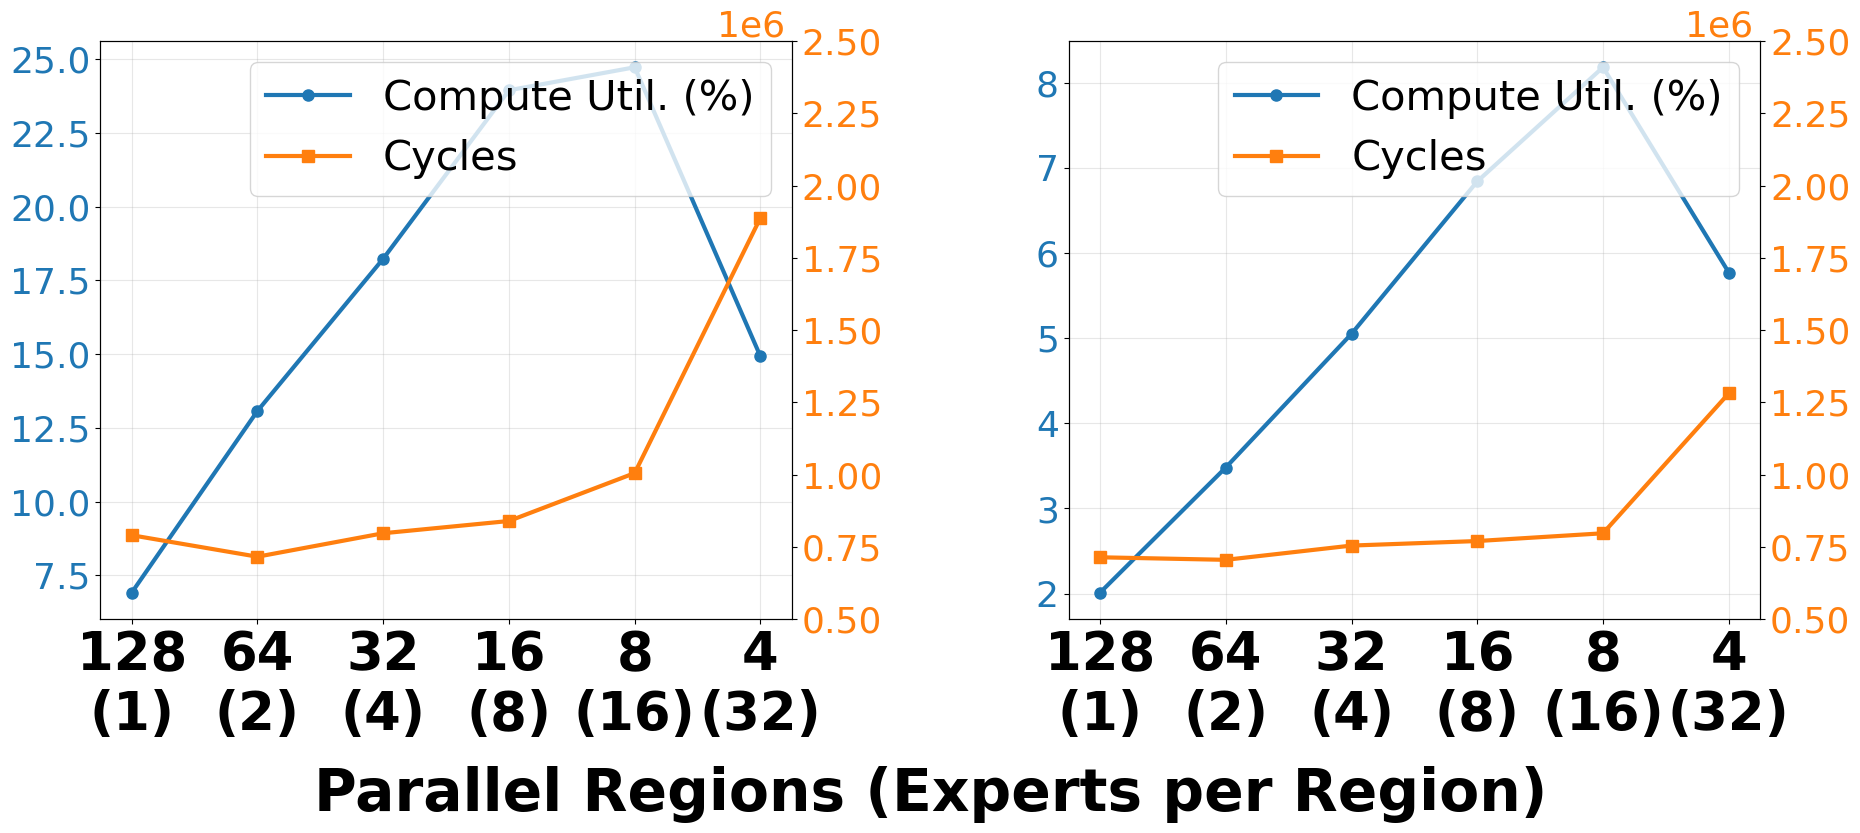

In [32]:
outfile = "./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_tiling.pdf"

on_chip_scale=(1*1e4,10*1e4)
allocated_flops_scale=(1*1e5,10*1e5)
cycles_scale=(0.5*1e6,2.5*1e6)
bandwidth_scale_2=(0,100)

utilization_scale_1=None
utilization_scale_2=None
# cycles_scale=None


create_two_csv_plots_pdf(csv_file_1='./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_revet_128_4.csv',
    csv_file_2='./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_round_1_f48_timeshare_membound_dyn_tile_128_4.csv',
    output_pdf=outfile,
    utilization_scale_1=utilization_scale_1, 
    cycles_scale_1=cycles_scale, 
    utilization_scale_2=utilization_scale_2, 
    cycles_scale_2=cycles_scale)

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

def cycle_raw_comp_utilization(csv_file, output_file=None, utilization_scale=None, cycles_scale=None):
    """
    Create a multi-axis line chart from a single CSV file.
    
    Parameters:
    csv_file (str): Path to CSV file
    output_file (str, optional): Path to save the plot
    utilization_scale (tuple, optional): Y-axis scale for utilization
    cycles_scale (tuple, optional): Y-axis scale for cycles
    """
    axis_font = 40
    legend_font = 28
    tick_font = 32
    x_tick_size = 32
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    
    # Read CSV file
    df_combined = pd.read_csv(csv_file)
    
    # Create display names from n_par_region column
    display_names = df_combined['n_par_region'].tolist()
    display_names = [f'{name}\n({128 // name})' for name in display_names]

    # Set up the plot with multiple y-axes
    fig, ax1 = plt.subplots(figsize=(10, 8.5))
    
    # Position of points on X axis
    x_pos = np.arange(len(display_names))
    
    # baseline_utilization = df_combined['utilization(%)'].iloc[0]

    # ax1.set_xlabel('Parallel Regions\n(Experts per Region)', fontsize=axis_font, labelpad=20)
    
    # Create first y-axis for utilization
    line1 = ax1.plot(x_pos, df_combined['utilization(%)'], 
                     color=color_palette[0], marker='o', linewidth=3, 
                     markersize=8, label=f'Compute Util. (%)')
    
    # Customize first y-axis (for utilization)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(display_names, ha='center', fontsize=x_tick_size)
    ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    
    # Create second y-axis for cycles
    ax2 = ax1.twinx()
    line2 = ax2.plot(x_pos, df_combined['cycles'], 
                     color=color_palette[2], marker='s', linewidth=3, 
                     markersize=8, label='Cycles')
    
    # Customize second y-axis (for cycles)
    ax2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_offset_text = ax2.yaxis.get_offset_text()
    ax2_offset_text.set_fontsize(tick_font)
    ax2_offset_text.set_position((0.99, 1.02))  # (x, y) in axis coordinates
    
    # ==================== Set Range ====================
    if utilization_scale is not None:
        ax1.set_ylim(utilization_scale) # utilization
    if cycles_scale is not None:
        ax2.set_ylim(cycles_scale) # cycles
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    # Create a single legend with all elements
    all_handles = lines1 + lines2
    all_labels = labels1 + labels2
    ax1.legend(all_handles, all_labels, loc='upper right', fontsize=legend_font)
    
    # Add grid
    ax1.grid(True, alpha=0.3)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save plot if output file specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")
    
    # Show plot
    plt.show()

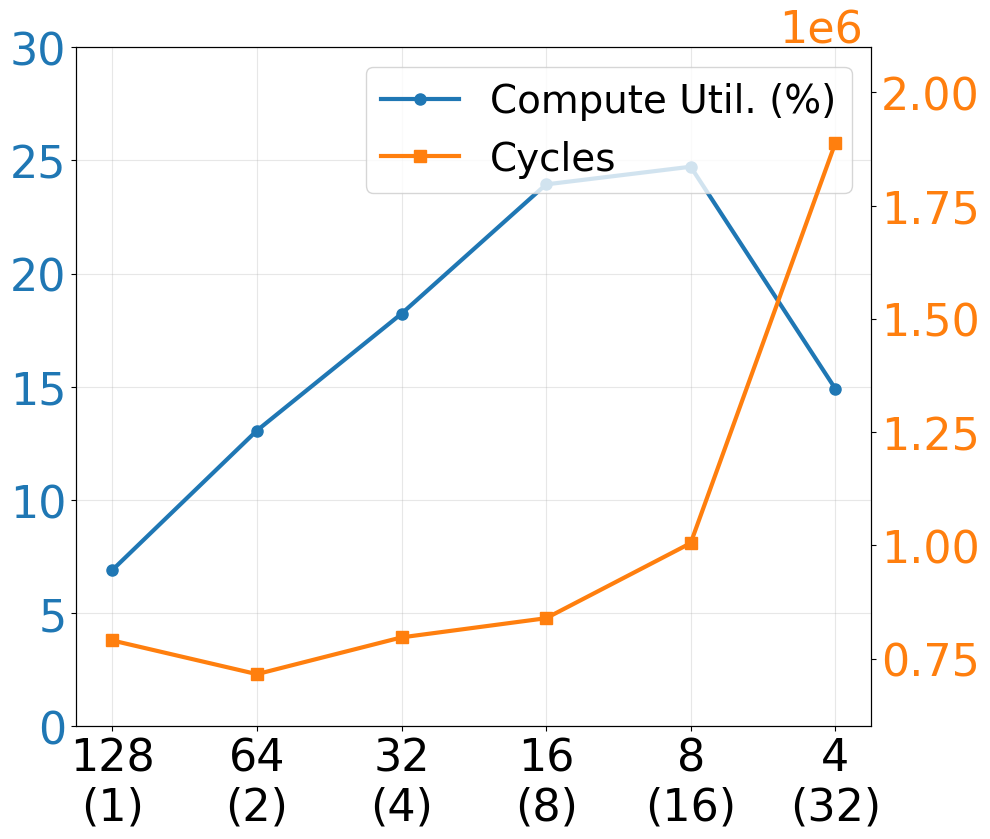

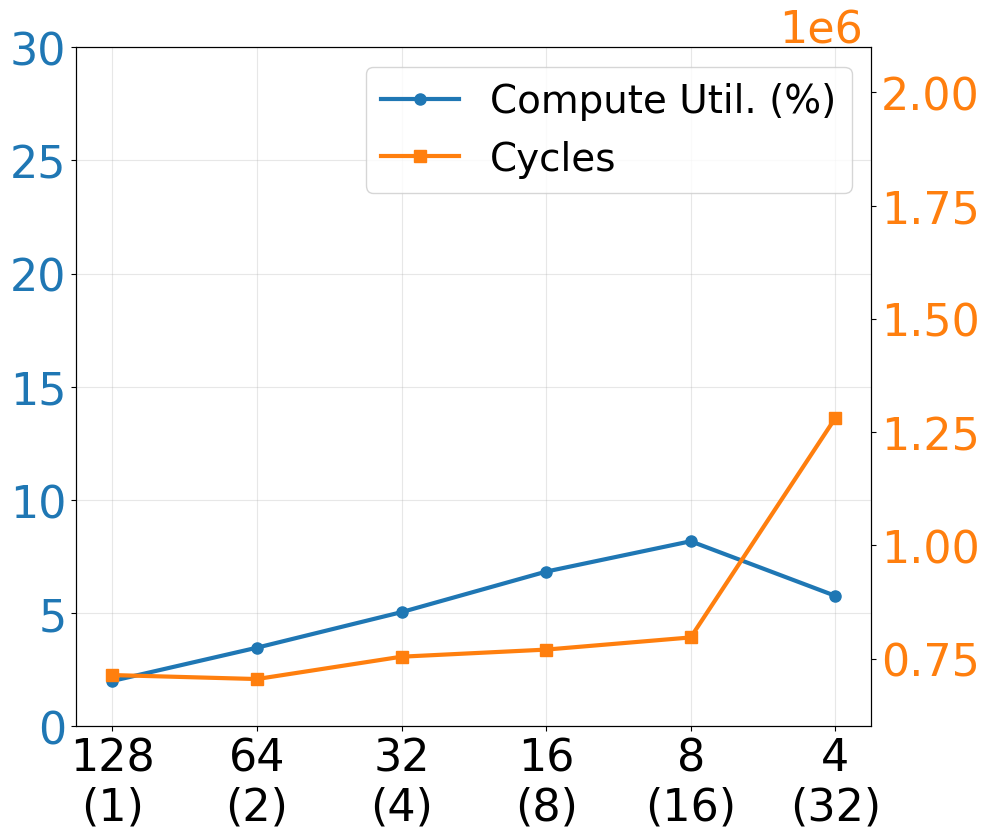

In [48]:
csv_file_1='./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_revet_128_4.csv'
csv_file_2='./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_round_1_f48_timeshare_membound_dyn_tile_128_4.csv'

output_file1 = "./timeshare_mem_bound/figure/qwen_iter032_layer_012_n32_comp_util.pdf"
output_file2 = "./timeshare_mem_bound/figure/qwen_iter032_layer_012_ndyn_comp_util.pdf"

output_file1 = None
output_file2 = None

utilization_scale = (0,30) # util
cycles_scale = (0.6*1e6,2.1*1e6) # cycles

# utilization_scale = None
# cycles_scale = None


cycle_raw_comp_utilization(csv_file_1, output_file=output_file1, utilization_scale=utilization_scale, cycles_scale=cycles_scale)
cycle_raw_comp_utilization(csv_file_2, output_file=output_file2, utilization_scale=utilization_scale, cycles_scale=cycles_scale)

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

def cycle_raw_comp_utilization(csv_file, output_file=None, utilization_scale=None, cycles_scale=None,
                              util_hlines=None, cycles_hlines=None):
    """
    Create a multi-axis line chart from a single CSV file.
    
    Parameters:
    csv_file (str): Path to CSV file
    output_file (str, optional): Path to save the plot
    utilization_scale (tuple, optional): Y-axis scale for utilization
    cycles_scale (tuple, optional): Y-axis scale for cycles
    util_hlines (list, optional): Y-values for horizontal lines on utilization axis
    cycles_hlines (list, optional): Y-values for horizontal lines on cycles axis
    """
    axis_font = 40
    legend_font = 28
    tick_font = 32
    x_tick_size = 32
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    
    # Read CSV file
    df_combined = pd.read_csv(csv_file)
    
    # Create display names from n_par_region column
    display_names = df_combined['n_par_region'].tolist()
    display_names = [f'{name}\n({128 // name})' for name in display_names]

    # Set up the plot with multiple y-axes
    fig, ax1 = plt.subplots(figsize=(10, 9))
    
    # Position of points on X axis
    x_pos = np.arange(len(display_names))
    
    # baseline_utilization = df_combined['utilization(%)'].iloc[0]

    ax1.set_xlabel('Parallel Regions\n(Experts per Region)', fontsize=axis_font, labelpad=20)
    
    # Create first y-axis for utilization
    line1 = ax1.plot(x_pos, df_combined['utilization(%)'], 
                     color=color_palette[0], marker='o', linewidth=3, 
                     markersize=8, label=f'Compute Util.')
    
    # Customize first y-axis (for utilization)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(display_names, ha='center', fontsize=x_tick_size)
    ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)

    ax1.set_ylabel('Utilization (%)', fontsize=axis_font, labelpad=10)
    
    # Create second y-axis for cycles
    ax2 = ax1.twinx()
    line2 = ax2.plot(x_pos, df_combined['cycles'], 
                     color=color_palette[2], marker='s', linewidth=3, 
                     markersize=8, label='Cycles')
    
    # Customize second y-axis (for cycles)
    ax2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_offset_text = ax2.yaxis.get_offset_text()
    ax2_offset_text.set_fontsize(tick_font)
    ax2_offset_text.set_position((0.99, 1.02))  # (x, y) in axis coordinates

    ax2.set_ylabel('Performance (cycles)', fontsize=axis_font, labelpad=10)
    
    # ==================== Set Range ====================
    if utilization_scale is not None:
        ax1.set_ylim(utilization_scale) # utilization
    if cycles_scale is not None:
        ax2.set_ylim(cycles_scale) # cycles
    
    # ==================== Add Red Horizontal Lines ====================
    # Add horizontal lines for utilization axis (left y-axis)
    if util_hlines:
        for i, y_val in enumerate(util_hlines):
            ax1.axhline(y=y_val, color='red', linestyle='--', linewidth=2, alpha=0.8)
            # Add text label above the line (you can customize the text for each line)
            ax1.text(x_pos[-1], y_val + (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.02, 
                    f'Target: {y_val}%', 
                    color='red', fontsize=20, ha='right', va='bottom')
    
    # Add horizontal lines for cycles axis (right y-axis)  
    if cycles_hlines:
        for i, y_val in enumerate(cycles_hlines):
            ax2.axhline(y=y_val, color='red', linestyle='--', linewidth=2, alpha=0.8)
            if i>0:
                percentile = 1
                if y_val == 754098:
                    percentile = 5
                # Add text label above the line
                ax2.text(x_pos[0], y_val + (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.02, 
                        f'   < {percentile}%', 
                        color='red', fontsize=x_tick_size, ha='left', va='bottom')
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    # Create a single legend with all elements
    all_handles = lines1 + lines2
    all_labels = labels1 + labels2
    ax1.legend(all_handles, all_labels, loc='upper left', fontsize=legend_font)
    
    # Add grid
    ax1.grid(True, alpha=0.3)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save plot if output file specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")
    
    # Show plot
    plt.show()


Plot saved to ./timeshare_mem_bound/figure/qwen_iter032_layer_012_n32_comp_util.pdf


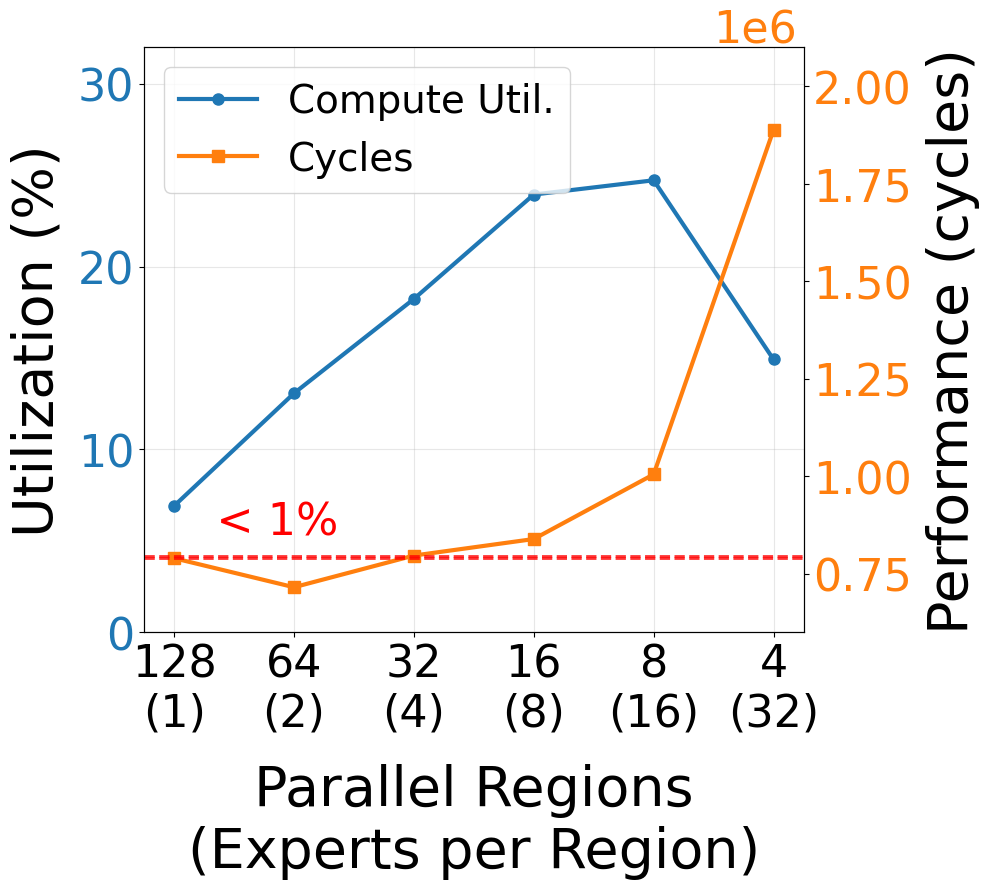

Plot saved to ./timeshare_mem_bound/figure/qwen_iter032_layer_012_ndyn_comp_util.pdf


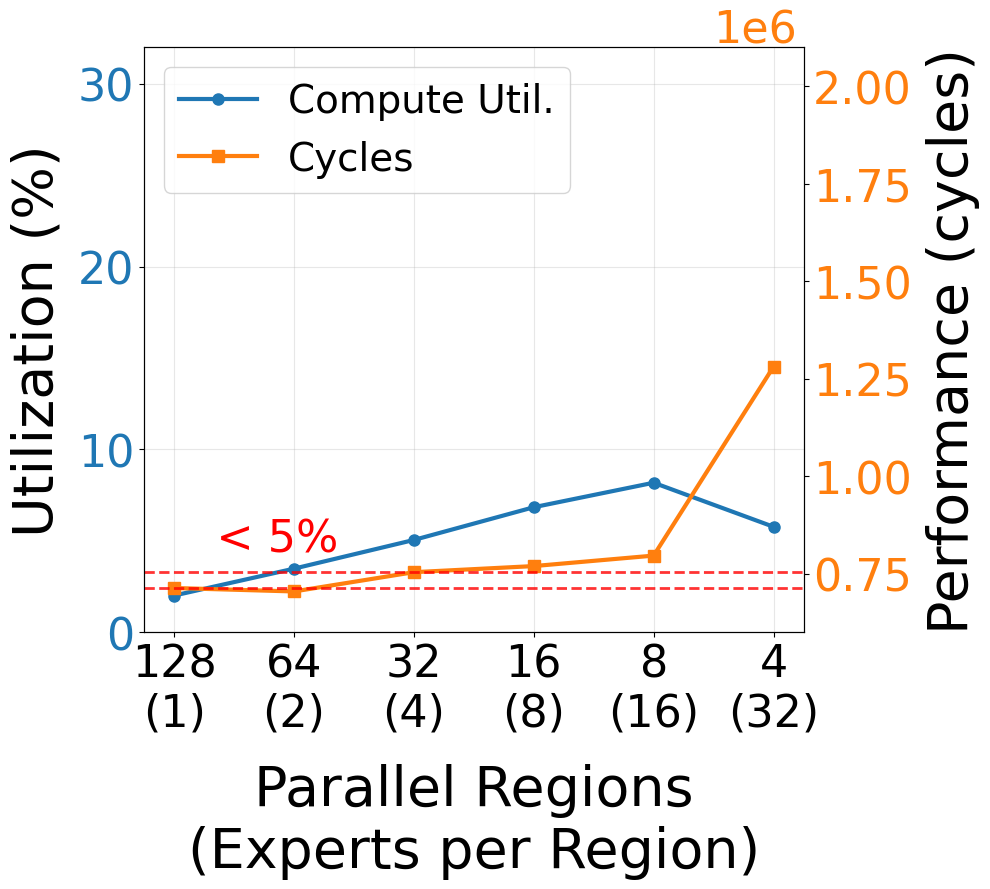

In [43]:
csv_file_1='./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound_revet_128_4.csv'
csv_file_2='./timeshare_mem_bound/figure/qwen_2048_768_iter032_layer_012_round_1_f48_timeshare_membound_dyn_tile_128_4.csv'

output_file1 = "./timeshare_mem_bound/figure/qwen_iter032_layer_012_n32_comp_util.pdf"
output_file2 = "./timeshare_mem_bound/figure/qwen_iter032_layer_012_ndyn_comp_util.pdf"

# output_file1 = None
# output_file2 = None

utilization_scale = (0,32) # util
cycles_scale = (0.6*1e6,2.1*1e6) # cycles

# utilization_scale = None
# cycles_scale = None


cycle_raw_comp_utilization(csv_file_1, output_file=output_file1, utilization_scale=utilization_scale, cycles_scale=cycles_scale,cycles_hlines=[789895, 796725])
cycle_raw_comp_utilization(csv_file_2, output_file=output_file2, utilization_scale=utilization_scale, cycles_scale=cycles_scale,cycles_hlines=[713539, 754098])